# Setup

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import os
import glob
import pandas as pd
import arviz as az
import pymc as pm
from scipy.special import expit as logistic
import pingouin as pg
import warnings
from tabulate import tabulate
import seaborn as sns

## Setup

In [2]:
#Plotting
plt.rcParams.update({'font.size': 18})
color_t1 = '#ca0020'
color_t2 = '#0571b0'

color_a = '#7b3294'
color_b = '#008837'

color_bottom = '#d01c8b'
color_top = '#4dac26'

#Set figure path and extension
fig_path = '/Users/jonathanwood/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofDelaware-o365/Team-CHS-PT-Morton Lab - Split-Belt Recal - Jonathan - Split-Belt Recal - Jonathan/Docs/Writing/Test_Retest paper/Figures'

extension = '.eps'

In [3]:
#Random sampling
RANDOM_SEED = 61
num_samples = 1000

## Define functions

In [218]:
def UniqueVals(stims, responses):
    
    """
    Definition: Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

def bayes_simple_regression(y_data, x_data, intercept_prior, slope_prior):
        
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000

    #Calculate the posterior
    with pm.Model() as model:
        intercept = pm.Normal("intercept", mu=intercept_prior[0], sigma=intercept_prior[1])
        slope = pm.Normal("slope", mu=slope_prior[0], sigma=slope_prior[1])
        sigma = pm.Exponential("sigma", 0.05)
        mu = pm.Deterministic("mu", intercept + slope*x_data)
        y = pm.Normal("y",mu=mu, sigma=sigma, observed=y_data)
        prior_samples = pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
    
    return trace, prior_samples

def bayes_logisitic_regression(y_data, x1, x2, x3, prior):
    
    N = len(np.unique(x1))
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000
    
    #Build model using PM 
    with pm.Model() as Model:
        alpha = pm.Normal("alpha", mu=prior[0], sigma=prior[1], shape=N)
        B_movdir = pm.Normal("B_movdir", mu=prior[0], sigma=prior[1], shape=2)
        B_stims = pm.Normal("B_stims", mu=prior[0], sigma=prior[1])
        p = pm.Deterministic("p", pm.math.invlogit(alpha[x1] +
                                                   B_movdir[x2] + 
                                                   B_stims * x3))
        response = pm.Binomial("response", 1, p, observed=y_data)
        prior_samples = pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
        
    return trace, prior_samples

def bayes_onesamp_ttest(data, prior):
    
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000
    
    #Calculate the posterior
    with pm.Model() as Model:
        mu = pm.Normal("mu", mu=prior[0], sigma=prior[1])
        sigma = pm.Exponential("sigma", 0.05)
        y = pm.Normal("y",mu=mu, sigma=sigma, observed=data)
        prior_samples= pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
    
    return prior_samples, trace

def sim_responses_move_direction(move_dir, P_left):
    
    """
    Simulates response data where the response is based on the movement direction.
    The dependency on movement direction is given by P_left. For example, 
    if P_left = 1 or 0, the response will be fully dependent on movement direction. 
    If P_left = 1 and the movement direction is backward the response will be left 100% of the time.
    """
    
    y_sim = np.empty_like(move_dir)
    for trl_idx, direction in enumerate(move_dir):
        if direction==1:
            y_sim[trl_idx] = np.random.choice([0, 1], 1, replace=False, p=[1-P_left, P_left])
        else: 
            y_sim[trl_idx] = np.random.choice([0, 1], 1, replace=False, p=[P_left, 1-P_left])

    return y_sim

def calc_response_prob(movement_direction, responses):
    
    #Calcualtes the probability of responses based on movement direction
    
    responses_back = responses[movement_direction == 1]
    responses_fwd = responses[movement_direction == 0]
    
    P_left_back = sum(responses_back)/sum(movement_direction==1)
    P_left_fwd = sum(responses_fwd)/sum(movement_direction==0)
    
    return P_left_back, P_left_fwd

## Load data

In [5]:
# #Change the directory (work computer)
# os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')
#Change the directory (Jonathans Mac)
os.chdir('/Users/jonathanwood/Documents/GitHub/Split-Belt-AFC-Reliability/Data/TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

N = len(np.unique(DF.SID))
#Print the subjects
print('Included subjects =', np.unique(DF.SID))
print('N =', N)

Included subjects = ['TRTPSI_01' 'TRTPSI_02' 'TRTPSI_07' 'TRTPSI_08' 'TRTPSI_10' 'TRTPSI_11'
 'TRTPSI_12' 'TRTPSI_13' 'TRTPSI_14' 'TRTPSI_15' 'TRTPSI_16' 'TRTPSI_17'
 'TRTPSI_18']
N = 13


## Retrieve estimates

In [222]:
unique_tests = ['a','b']
alphas, betas = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        betas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[-1]

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_20676/2514294651.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


# Descriptive Stats

In [7]:
#Alphas
print('All Alphas = ' + str(round(np.mean(alphas))) + '+/-' + str(round(np.std(alphas))))
print('Test 1 Alphas = ' + str(round(np.mean(alphas[:,0]))) + '+/-' + str(round(np.std(alphas[:,0]))))
print('Test 2 Alphas = ' + str(round(np.mean(alphas[:,1]))) + '+/-' + str(round(np.std(alphas[:,1]))))

All Alphas = 14+/-15
Test 1 Alphas = 12+/-14
Test 2 Alphas = 15+/-16


In [8]:
#Betas
print('All Betas = ' + str(round(np.mean(betas))) + '+/-' + str(round(np.std(betas))))
print('Test 1 Betas = ' + str(round(np.mean(betas[:,0]))) + '+/-' + str(round(np.std(betas[:,0]))))
print('Test 2 Betas = ' + str(round(np.mean(betas[:,1]))) + '+/-' + str(round(np.std(betas[:,1]))))

All Betas = 18+/-6
Test 1 Betas = 18+/-6
Test 2 Betas = 17+/-6


In [9]:
#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]

print('Mean alpha diff = ' + str(round(np.mean(alpha_diff))) + '+/-' + str(round(np.std(alpha_diff))))
print('Mean beta diff = ' + str(round(np.mean(beta_diff))) + '+/-' + str(round(np.std(beta_diff))))

Mean alpha diff = -3+/-9
Mean beta diff = 1+/-5


In [10]:
#Means
alpha_mean = np.mean(alphas,axis=1)
beta_mean = np.mean(betas,axis=1)

In [11]:
#Limits of agreement
uplimit_alpha = np.mean(alpha_diff) + 1.96*np.std(alpha_diff, ddof=1)
lolimit_alpha = np.mean(alpha_diff) - 1.96*np.std(alpha_diff, ddof=1)

uplimit_beta = np.mean(beta_diff) + 1.96*np.std(beta_diff, ddof=1)
lolimit_beta = np.mean(beta_diff) - 1.96*np.std(beta_diff, ddof=1)

n         r         CI95%     p-val   BF10     power
pearson  13  0.390993  [-0.2, 0.78]  0.186489  0.754  0.270902

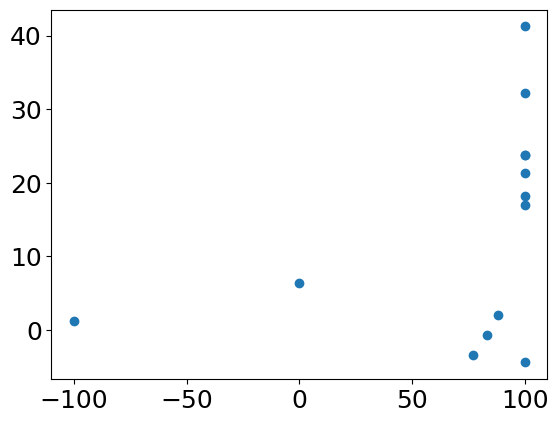

In [12]:
waterloo = np.array([100, 0, 100, 100, 100, 100, -100, 77, 100, 100, 100, 88, 83])
plt.plot(waterloo,alpha_mean,'o')
pg.corr(waterloo,alpha_mean)

In [13]:
# Calculcate middle 50% to compare to other studies 
x = np.arange(-100,100.001,0.001)

unique_tests = ['a','b']
#Extract the final estimates of the alpha and beta values
percision = np.empty((len(grp_subjs),2))
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        a = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        b = test[test.Test==test_id].Beta_EV.values[-1]
        
        psi = norm.cdf(x,a,b)

        prct_25_idx = np.argmin(np.abs(psi-0.25))
        prct_75_idx = np.argmin(np.abs(psi-0.75))
        percision[subj_name_idx, test_id_idx] = x[prct_75_idx] - x[prct_25_idx]
        
        # fig, ax = plt.subplots()
        # ax.plot(x, psi)
        # ax.axvline(x[prct_75_idx])
        # ax.axvline(x[prct_25_idx])
        # ax.axhline(0.75)
        # ax.axhline(0.25)


/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_20676/3043995459.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


In [14]:
np.mean(percision,axis=0)

array([24.47253846, 23.50215385])

In [15]:
np.std(percision,axis=0, ddof=1)

array([8.02725811, 8.59995266])

# Impact of movement direction

First we use a logistiic regression to determine the impact of movement direction on participants decisions

## Define the model

Because each response is binary, we model each one as a Binomial distribution of size 1. The probability of the response is modeled as a logistic regression. The log-odds of the probability is the outcome variable. The predictor variables are movement direction (one each for backward and forward), and the stimulus position. There is also a unqiue intercept for each individual participant because every person has a different bias.

$$ L \approx Binomial(1,p) $$
$$ logit(p) = \alpha[x_{SID}] + \beta_{move_dir}[x_{movedir}] + \beta_{stims} * x_{stims}$$
$$ alpha \approx Normal(0,1) $$
$$ \beta_{move_dir} \approx Normal(0,1) $$
$$ \beta_{stims} \approx Normal(0,1) $$

## Define the priors 

For this model, I do not have different prior assumptions for a value for each parameter so I set them as the same. In other words, I have no reason to beleive any of these variables is going to impact the probability of responding left more than another. Ill just center them all around 0.5 probability with a normal distribution N(0,1).


## Organize variables

* y = responses (1='left', 0='right')
* x_move_dir = movement direction (1=backwards, 0=forwards)
* x_stims = stimulus positions (continuous) 
* x_SID = indexing variable for each subject

In [16]:
# Set the variables
y = np.array(DF.BinaryResponses,dtype=int) #Binary responses (1=left, 0=right)
x_move_dir = np.array(DF.AllStarts.values > DF.AllStims.values, dtype=int) # 1 for backwards to the stim postiion, 0 for forwards
x_stims = [DF.AllStims.values[i] + np.round(DF.BslDiff.values[i])  for i in range(len(DF.AllStims.values))]
x_stims = np.array(x_stims)
x_SID = [np.ones(150, dtype=int)*int(i) for i in range(len(np.unique(DF.SID)))]
x_SID = np.concatenate(x_SID)

## Calculcate the posterior

In [48]:
trace_logistic, prior_samples_logistic = bayes_logisitic_regression(y_data=y, x1=x_SID, x2=x_move_dir, x3=x_stims, prior=[0,1])

Sampling: [B_movdir, B_stims, alpha, response]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, B_movdir, B_stims]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 58 seconds.


## Model checks

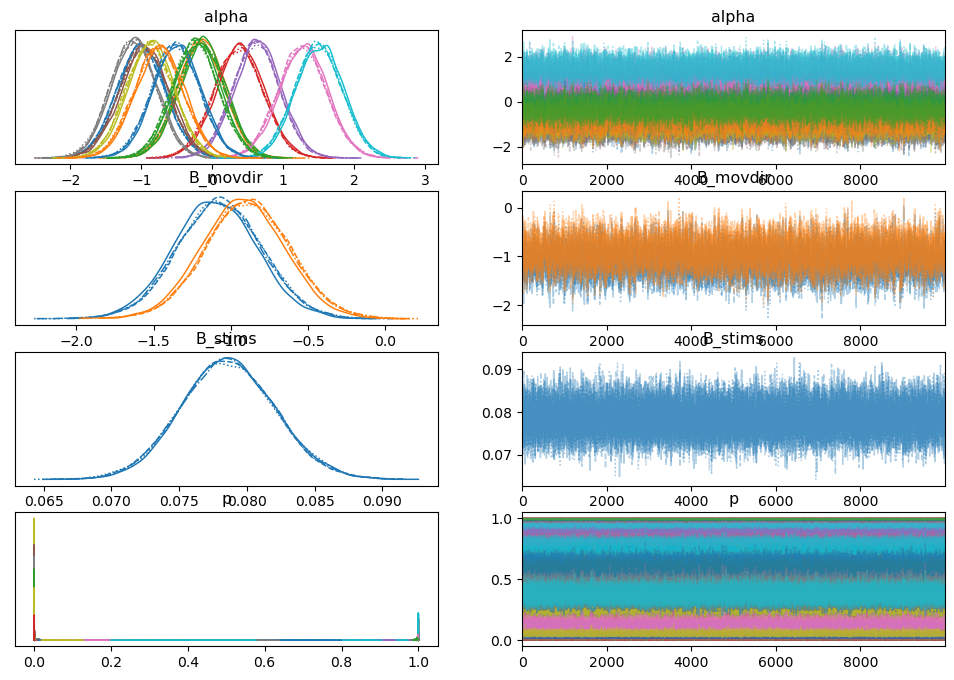

In [18]:
#Trace
az.plot_trace(trace_logistic)
plt.show()

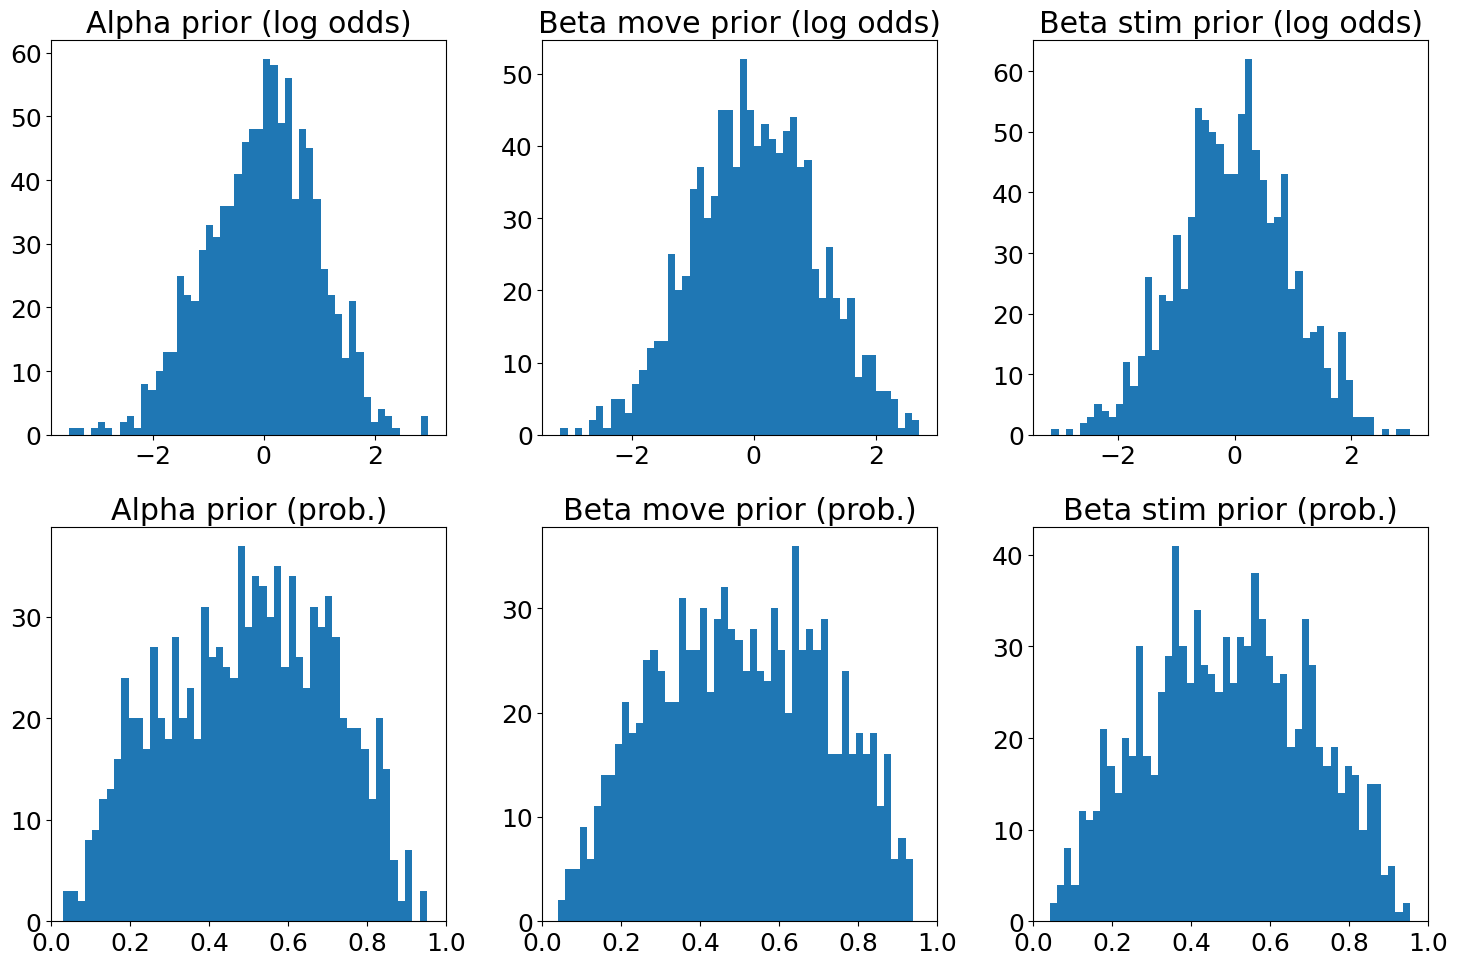

In [268]:
#Priors
log_prior_stack = az.extract(prior_samples_logistic.prior)

fig, ax = plt.subplots(2,3, figsize=(15,10), tight_layout=True)
ax[0,0].hist(log_prior_stack.alpha.values[0,:],50)
ax[0,0].set(title='Alpha prior (log odds)')
ax[0,1].hist(log_prior_stack.B_movdir.values[0,:],50)
ax[0,1].set(title='Beta move prior (log odds)')
ax[0,2].hist(log_prior_stack.B_stims.values,50)
ax[0,2].set(title='Beta stim prior (log odds)')

#Priors
ax[1,0].hist(logistic(log_prior_stack.alpha.values[0,:]),50)
ax[1,0].set(title='Alpha prior (prob.)', xlim=(0,1))
ax[1,1].hist(logistic(log_prior_stack.B_movdir.values[0,:]),50)
ax[1,1].set(title='Beta move prior (prob.)', xlim=(0,1))
ax[1,2].hist(logistic(log_prior_stack.B_stims.values),50)
ax[1,2].set(title='Beta stim prior (prob.)', xlim=(0,1))
plt.show()

**Prior justification:**

For priors, the one I use in the paper is mu=0, sigma=1. This one is pretty uninformative in probability space. 
I tried mu=0, sigma=0.5. This is tighter in probability space. This doesnt really change the results at all. 
Also tried mu=0, sigma=0.1, this is a really tight disitribution in probability space around 0.5, this changes the log posteriors but not the overall results. 
Now for wider priors, the wider they get the more they actually favor the extremes of the probability distribution (high concentrations around 0 and 1)
I tried mu=0, sigma=5, this really widens the uncertainty, but really does not change the results
The prior of mu=0, sigma=2 is pretty much uniform in probability space.

**Rope justification:**

If movement directions were completely unbiased, 19 of the 38 backward movements would be "left" responses and 17-18 of the 37 forward movements would be "right" responses. For practical purposes, plus or minus 2 responses should be equalivant to no bias for each movement direction. If we assume the backward movements are more biased for left and the forwards movements are more biased for right, 2 responses in terms of probability equates to 0.55 for the backwards movement and 0.43. This means a difference in probability between -0.12 to 0.12 should be considered equivilant. Here I tighten the range a bit to -0.1 to 0.1 being practically equivilant.

In terms of log-odds, this equates to -2.2 to 2.2.

## Analyze posterior

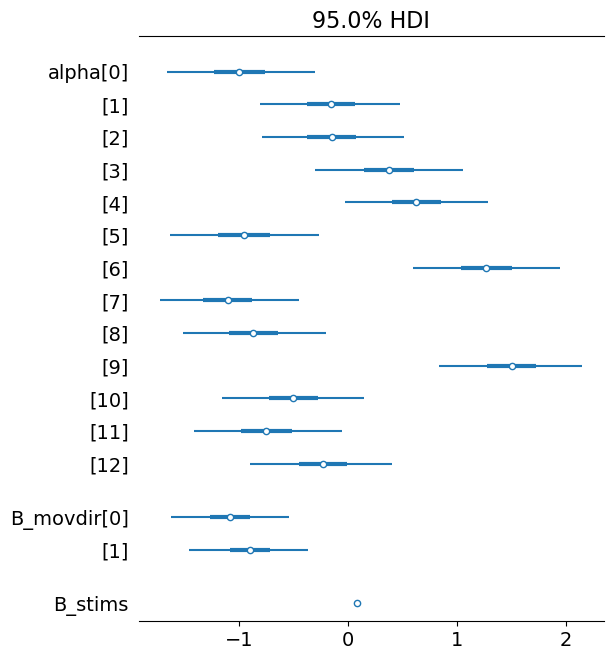

In [50]:
#Summary in log space
az.plot_forest(trace_logistic, var_names=["alpha", "B_movdir", "B_stims"], combined=True, hdi_prob=0.95)
plt.show()

In [51]:
log_summary = az.summary(trace_logistic, var_names=["alpha", "B_movdir", "B_stims"], hdi_prob=0.95)
log_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]    -1.000  0.345    -1.665     -0.309      0.004    0.003    7125.0   
alpha[1]    -0.158  0.329    -0.812      0.477      0.004    0.003    6461.0   
alpha[2]    -0.150  0.335    -0.794      0.515      0.004    0.003    6613.0   
alpha[3]     0.376  0.347    -0.306      1.053      0.004    0.003    7134.0   
alpha[4]     0.629  0.334    -0.025      1.282      0.004    0.003    6556.0   
alpha[5]    -0.955  0.350    -1.641     -0.271      0.004    0.003    7018.0   
alpha[6]     1.272  0.346     0.594      1.944      0.004    0.003    7234.0   
alpha[7]    -1.108  0.327    -1.733     -0.456      0.004    0.003    6445.0   
alpha[8]    -0.871  0.334    -1.518     -0.206      0.004    0.003    6710.0   
alpha[9]     1.500  0.338     0.832      2.154      0.004    0.003    6726.0   
alpha[10]   -0.504  0.336    -1.156      0.150      0.004    0.003    6701.0   
alpha[11]   -0.752  0.347    -1.422     -0.055      0.004    0.003    7146.0   
alpha[12]   -0.231  0.331    -0.904      0.399      0.004    0.003    6509.0   
B_movdir[0] -1.083  0.276    -1.630     -0.543      0.004    0.003    4644.0   
B_movdir[1] -0.901  0.276    -1.460     -0.371      0.004    0.003    4584.0   
B_stims      0.079  0.003     0.072      0.085      0.000    0.000   26937.0   

             ess_tail  r_hat  
alpha[0]      13589.0    1.0  
alpha[1]      12240.0    1.0  
alpha[2]      11747.0    1.0  
alpha[3]      13829.0    1.0  
alpha[4]      11578.0    1.0  
alpha[5]      13257.0    1.0  
alpha[6]      13032.0    1.0  
alpha[7]      12380.0    1.0  
alpha[8]      12896.0    1.0  
alpha[9]      13374.0    1.0  
alpha[10]     11990.0    1.0  
alpha[11]     12853.0    1.0  
alpha[12]     12322.0    1.0  
B_movdir[0]    7356.0    1.0  
B_movdir[1]    7929.0    1.0  
B_stims       29815.0    1.0

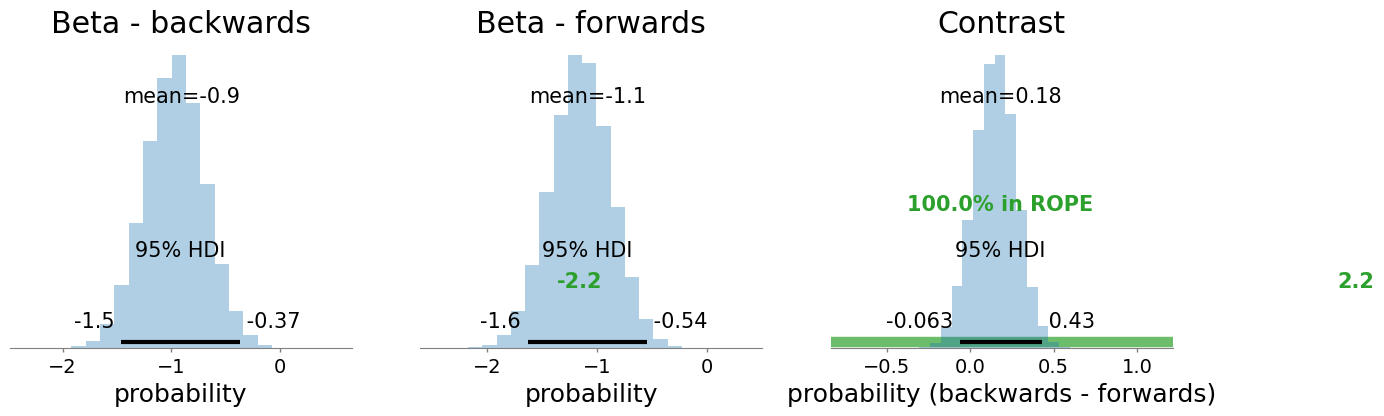

In [228]:
#Plot posterior
log_posterior_stack = az.extract(trace_logistic.posterior)
#Note: for indexing the movement direction posterior, 1 = backwards, 0 = forwards

fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(log_posterior_stack.B_movdir.values[1,:],kind='hist',hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Beta - backwards',xlabel='probability')
az.plot_posterior(log_posterior_stack.B_movdir.values[0,:],kind='hist',hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Beta - forwards',xlabel='probability')
az.plot_posterior(log_posterior_stack.B_movdir.values[1,:] - log_posterior_stack.B_movdir.values[0,:],kind='hist', rope=[-2.2, 2.2], hdi_prob=0.95, ax=ax[2])
ax[2].set(title='Contrast',xlabel='probability (backwards - forwards)')
plt.show()

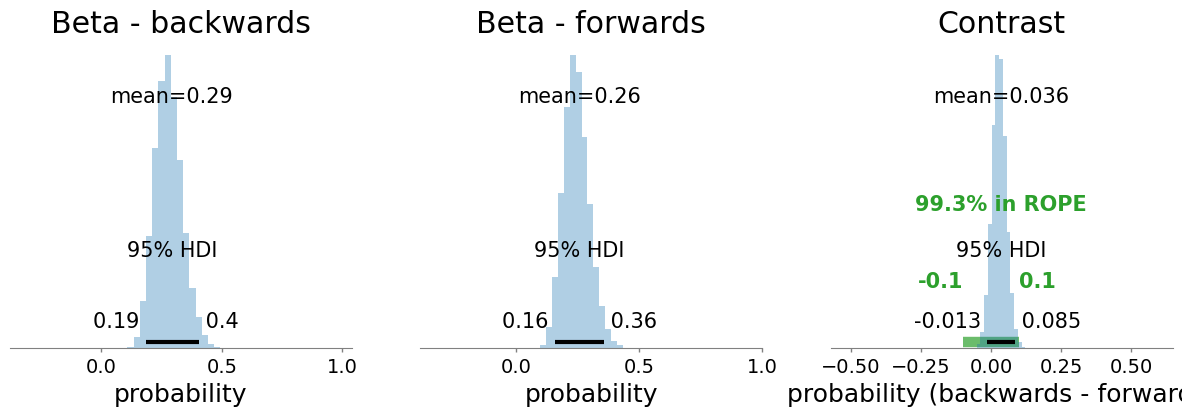

In [229]:
#Plot posterior
log_posterior_stack = az.extract(trace_logistic.posterior)
#Note: for indexing the movement direction posterior, 1 = backwards, 0 = forwards

fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(logistic(log_posterior_stack.B_movdir.values[1,:]),kind='hist',hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Beta - backwards',xlabel='probability')
az.plot_posterior(logistic(log_posterior_stack.B_movdir.values[0,:]),kind='hist',hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Beta - forwards',xlabel='probability')
az.plot_posterior(logistic(log_posterior_stack.B_movdir.values[1,:]) - logistic(log_posterior_stack.B_movdir.values[0,:]),kind='hist',rope=[-0.1, 0.1], hdi_prob=0.95, ax=ax[2])
ax[2].set(title='Contrast',xlabel='probability (backwards - forwards)')
plt.show()

## Validation 

Sampling: [B_movdir, B_stims, alpha, response]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, B_movdir, B_stims]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 55 seconds.


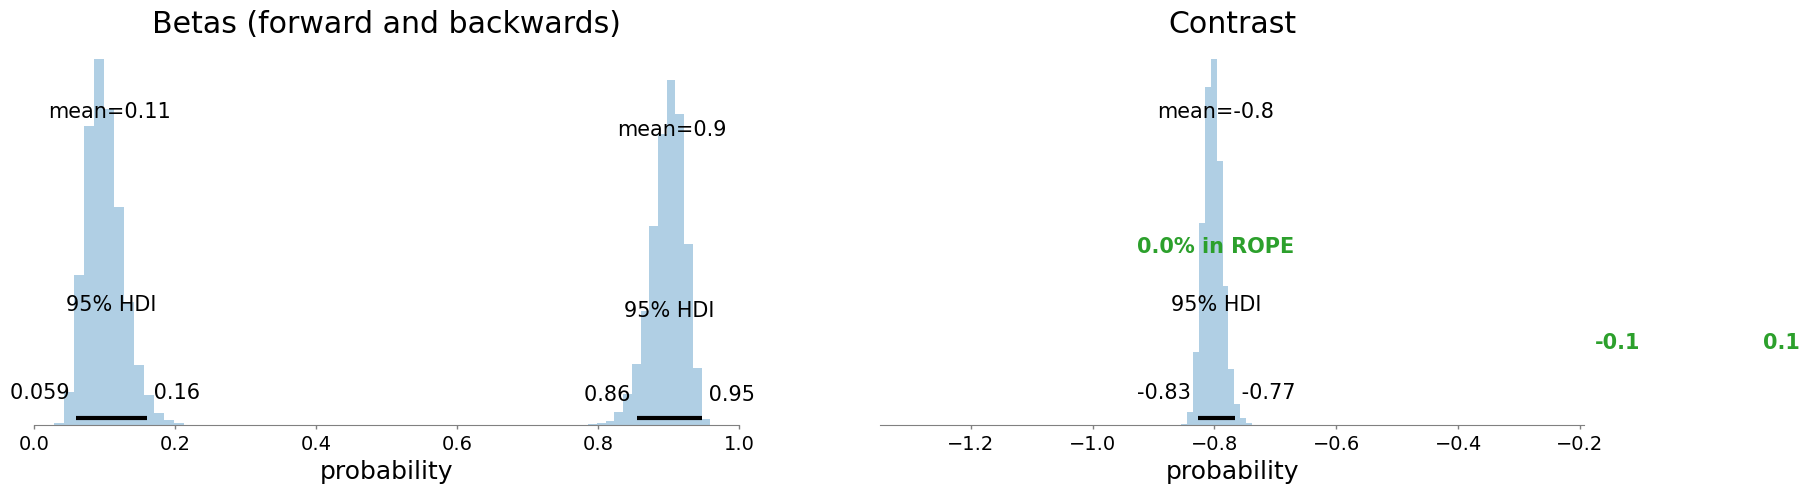

In [59]:
#Simulated responses strongly biased by movement direction
P_left = 0.9
y_sim = sim_responses_move_direction(x_move_dir, P_left)
#Calculcate bias in simulated responses
sim_pL_bck, sim_pL_fwd = calc_response_prob(x_move_dir, y_sim)

#Logistic regression with simulated data
trace_logistic_sim, _ = bayes_logisitic_regression(y_data=y_sim, x1=x_SID, x2=x_move_dir, x3=x_stims, prior=[0,1])

log_sim_posterior_stack = az.extract(trace_logistic_sim.posterior)

#Plot the posterior for movement direction
fig, ax = plt.subplots(1,2, figsize=(20,5))
az.plot_posterior(logistic(log_sim_posterior_stack.B_movdir.values[1,:]),kind='hist',hdi_prob=0.95, ax=ax[0])
az.plot_posterior(logistic(log_sim_posterior_stack.B_movdir.values[0,:]),kind='hist',hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Betas (forward and backwards)', xlabel='probability', xlim=(0, 1))
az.plot_posterior(logistic(log_sim_posterior_stack.B_movdir.values[0,:]) - logistic(log_sim_posterior_stack.B_movdir.values[1,:]),kind='hist',rope=[-0.1, 0.1], hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Contrast',xlabel='probability')
plt.show()

## Plot

In [60]:
# Emperical movement direction probabilities
p_left_back, p_left_fwd = [],[]
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    movement_direction = np.array(test.AllStarts.values > test.AllStims.values, dtype=int)
    p_lft_indiv_bck, p_lft_indiv_fwd = calc_response_prob(movement_direction, test.BinaryResponses)
    p_left_back.append(p_lft_indiv_bck)
    p_left_fwd.append(p_lft_indiv_fwd)

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_20676/2510667259.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


In [255]:
contrast = logistic(log_posterior_stack.B_movdir.values[1,:]) - logistic(log_posterior_stack.B_movdir.values[0,:])
hdi_95_contrast = az.hdi(contrast, hdi_prob=0.95)
ROPE = 0.1
prct_in_rope = (np.sum((contrast>-ROPE) & (contrast<ROPE)) / len(contrast))*100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


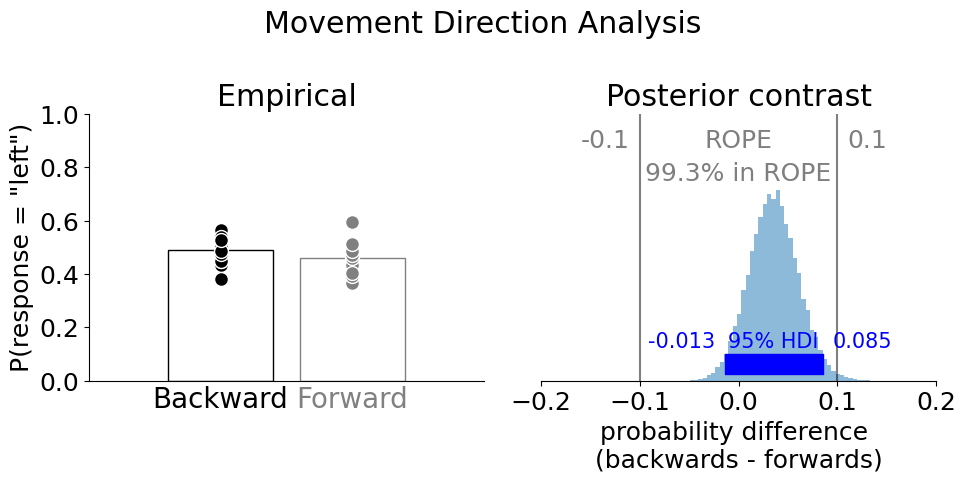

In [257]:
#Plot
# color_bottom = '#d01c8b'
# color_top = '#4dac26'
color_bottom = 'k'
color_top = 'gray'

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]}, tight_layout=True)

ax[0].plot(np.ones_like(p_left_back)*0, p_left_back, 'o', color=color_bottom, mec='w', ms=10)
ax[0].plot(np.ones_like(p_left_fwd), p_left_fwd, 'o', color=color_top, mec='w', ms=10)
ax[0].bar(0, np.mean(p_left_back), edgecolor=color_bottom, color='none')
ax[0].bar(1, np.mean(p_left_fwd), edgecolor=color_top, color='none')
ax[0].set(ylim=(0,1), xlim=(-1,2), xticks=[], title='Empirical', facecolor = "none", ylabel='P(response = "left")') 
ax[0].text(0, -0.1, 'Backward', color=color_bottom, size=20, ha='center')
ax[0].text(1, -0.1, 'Forward', color=color_top, size=20, ha='center')
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)

ax[1].vlines([-ROPE, ROPE], ymin=[0,0], ymax=[10000,10000], color='k', alpha=0.5)
ax[1].hist(contrast, 50, alpha=0.5)
ax[1].text(0, 3500, 'ROPE', ha='center', alpha=0.5)
ax[1].text(0, 3000, str(round(prct_in_rope,1)) + '% in ROPE', ha='center', alpha=0.5)

ax[1].text(-ROPE-0.01, 3500, '-0.1', ha='right', alpha=0.5)
ax[1].text(ROPE+0.01, 3500, '0.1', ha='left', alpha=0.5)
ax[1].fill_between(hdi_95_contrast, y1=np.zeros_like(hdi_95_contrast)+100, y2=np.zeros_like(hdi_95_contrast)+400, color='b')
ax[1].text(np.mean(contrast),500, '95% HDI', ha='center', color='b', size=15)
ax[1].text(hdi_95_contrast[0]-0.01, 500, str(np.round(hdi_95_contrast[0],3)), ha='right', size=15, color='b')
ax[1].text(hdi_95_contrast[1]+0.01, 500, str(np.round(hdi_95_contrast[1],3)), ha='left', size=15, color='b')
ax[1].set(title='Posterior contrast', xlabel='probability difference \n' + '(backwards - forwards)', yticks=[], xlim=(-0.2,0.2), ylim=(0,4000))
top_side = ax[1].spines["top"]
top_side.set_visible(False)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
left_side = ax[1].spines["left"]
left_side.set_visible(False)

plt.suptitle('Movement Direction Analysis')
plt.savefig(fig_path + '/Move_Dir_Fig' + extension, transparent=True, bbox_inches='tight', pad_inches=1, edgecolor='w', dpi=1500)
plt.show()

In [269]:
# Bayes factor
#first calculate the percent of posterior probability within the rope
prior_contrast = logistic(log_prior_stack.B_movdir.values[1,:])-logistic(log_prior_stack.B_movdir.values[0,:])
prior_in_rope = (np.sum((prior_contrast>-ROPE) & (prior_contrast<ROPE)) / len(prior_contrast))*100

#Calcualte bayes factor
BF_move_direction = prct_in_rope/prior_in_rope
BF_move_direction

3.676388888888889

# Bland-Altman analysis 

This analysis has 3 parts:
1. Determine if there is a bias in the differences between individual scores. A test with good agreement should not have a bias. 
2. Determine if there is a bias across different "true" scores. Our best guess for the true score is the mean between the individual scores. So we can perform a regression with the individual mean scores as the predictor variable and the difference in individual scores as the outcome variable. A test with good agreement will have a slope that is not different from 0, indicating that there is not a bias across the different "true" scores. 
3. Define the limits of agreement. Bland-altman defined the limits of agreement as the difference in individual scores that contains 95% of the data. 

## 1. Bias in score differences

### Define the model

Here I choose to model the difference between the scores as a normal distribtion.

$$ TestDifference \sim Normal(\mu, \sigma) $$
$$ \mu \sim Normal(0,20) $$
$$ \sigma \sim Exp(20) $$

### Define the priors 

The prior for mu is set around 0 with an SD of 20mm, while the prior for sigma is exponentnial with an expected value of 20

### Organize the variables

In [93]:
#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]

### Calculate the posteriors

In [94]:
#Alpha
prior_samples_abias, trace_alpha_bias, = bayes_onesamp_ttest(alpha_diff, prior=[0,20])
#Beta
prior_samples_bbias, trace_beta_bias = bayes_onesamp_ttest(beta_diff, prior=[0,20])

Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 24 seconds.
Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 24 seconds.


### Model checks

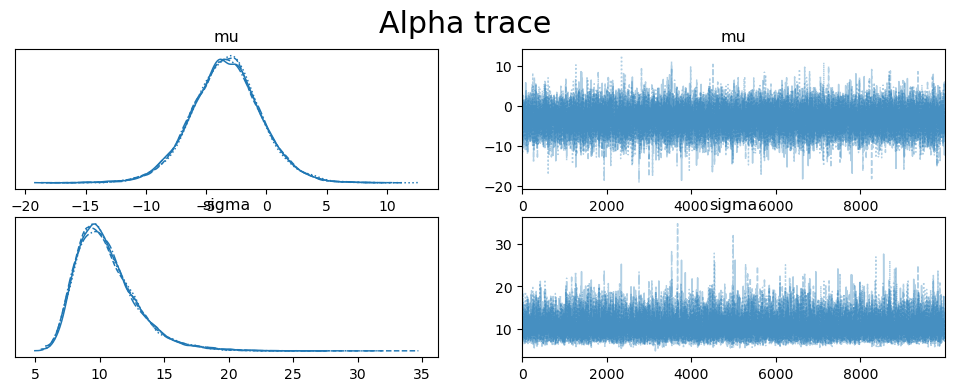

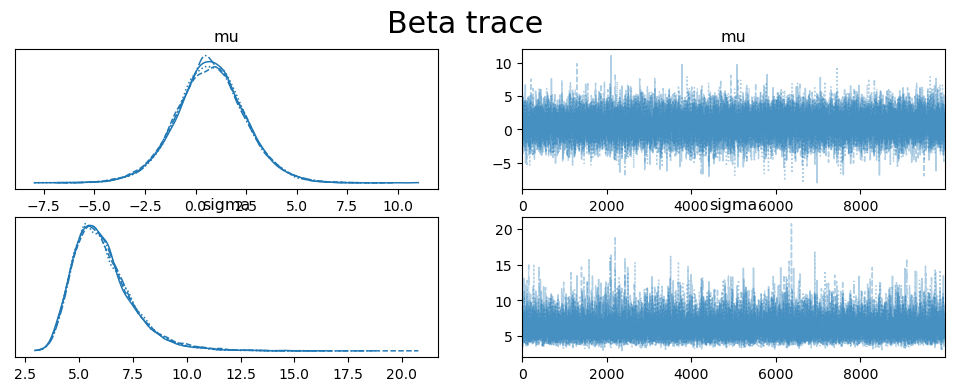

In [95]:
#Trace
#Alpha
az.plot_trace(trace_alpha_bias)
plt.suptitle('Alpha trace')
plt.show()
#Beta
az.plot_trace(trace_beta_bias)
plt.suptitle('Beta trace')
plt.show()

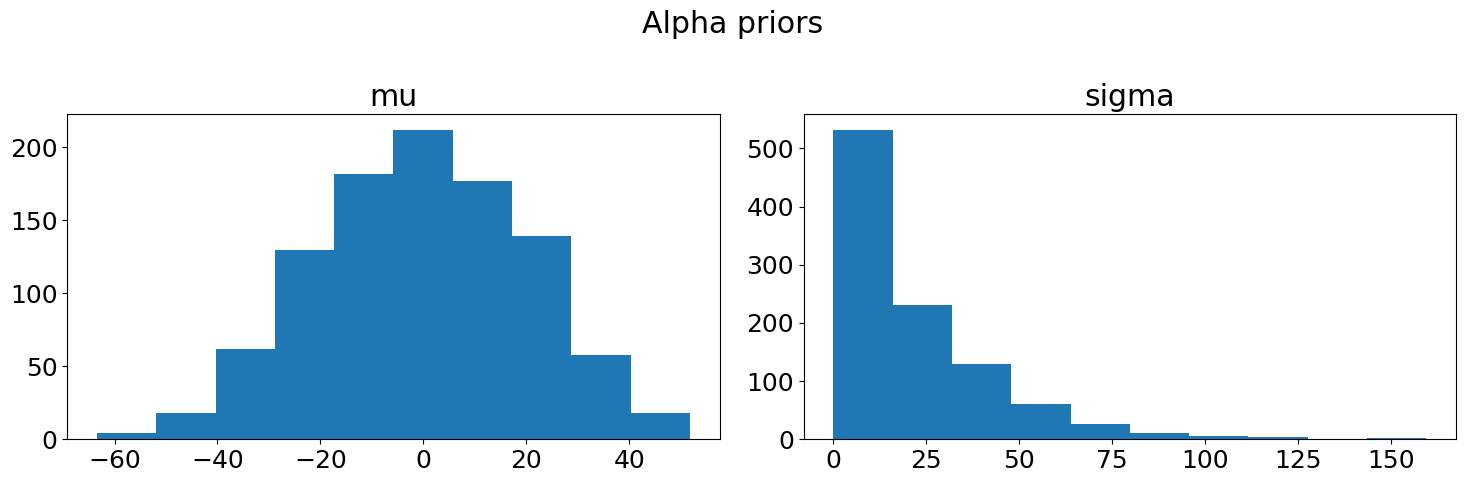

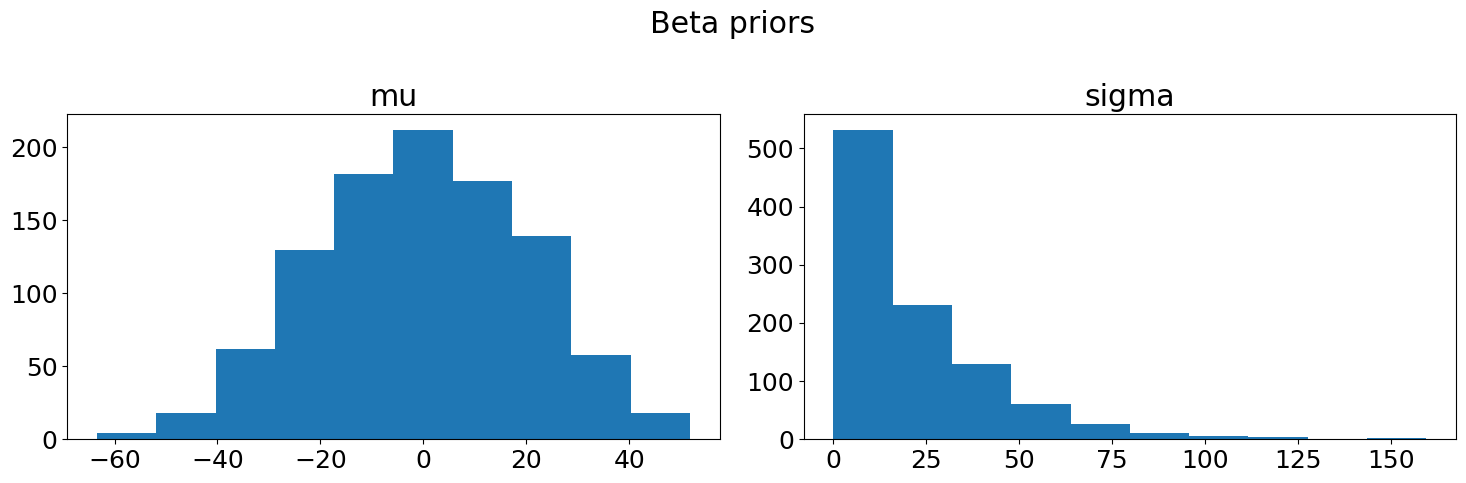

In [270]:
#Priors
abias_prior_stack = az.extract(prior_samples_abias.prior)
bbias_prior_stack = az.extract(prior_samples_bbias.prior)

#Alpha
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
ax[0].hist(abias_prior_stack.mu.values)
ax[0].set(title='mu')
ax[1].hist(abias_prior_stack.sigma.values)
ax[1].set(title='sigma')
plt.suptitle('Alpha priors')
plt.show()

#Beta
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
ax[0].hist(bbias_prior_stack.mu.values)
ax[0].set(title='mu')
ax[1].hist(bbias_prior_stack.sigma.values)
ax[1].set(title='sigma')
plt.suptitle('Beta priors')
plt.show()

**Prior Justification:**

Tried only a few priors for these. The one I use in the paper are mu=0, sigma=20. 
I tried making them really wide, super uninformative: mu=0, sigma=50. This does not change the results.
Also tried narrower priors, mu=0, sigma=5. This made the results more robust, meaning more of the posterior was in the ROPE for both, but overall, the results are unchanged. 
Next I modified the prior for sigma, the standard deviation of the normal distribution. 
The one I use for the paper is 0.05, an EV of 20. 
First, I tried a wider prior of 0.01, an EV of 100, this didnt change anything. 
Next, I went narrow with a prior of 1, and EV of 1, but this also does not change the results. 

**ROPE Justification:**

It is not clear how percise the propriocetive system is for the lower extremities. If we take a clue from research in upper extremity work, it looks like individuals can confidently detect differences within a range of about 20-30mm. Practical equivilance therefore should be smaller. For the purposes of our lower extremity task, which had intervals provided every 10mm, it is fair to assume that a difference of plus or minus 1 stimulus step is practically equivilant. Thus, any bias outside of 1cm in either direction can be considered a significant bias. 

In [266]:
rope_mu_diff = 5

### Analyze posterior

In [97]:
a_bias_summary = az.summary(trace_alpha_bias, var_names=["mu", "sigma"], hdi_prob=0.95)
b_bias_summary = az.summary(trace_beta_bias, var_names=["mu", "sigma"], hdi_prob=0.95)
print('Alpha posterior:')
display(a_bias_summary)
print('Beta posterior:')
display(b_bias_summary)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     -3.351  2.950    -9.121      2.542      0.018    0.014   29209.0   
sigma  10.516  2.385     6.441     15.151      0.016    0.012   23337.0   

       ess_tail  r_hat  
mu      23905.0    1.0  
sigma   23006.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.742  1.740    -2.722      4.193      0.011    0.009   27523.0   
sigma  6.114  1.425     3.765      8.916      0.009    0.007   27526.0   

       ess_tail  r_hat  
mu      22002.0    1.0  
sigma   24367.0    1.0

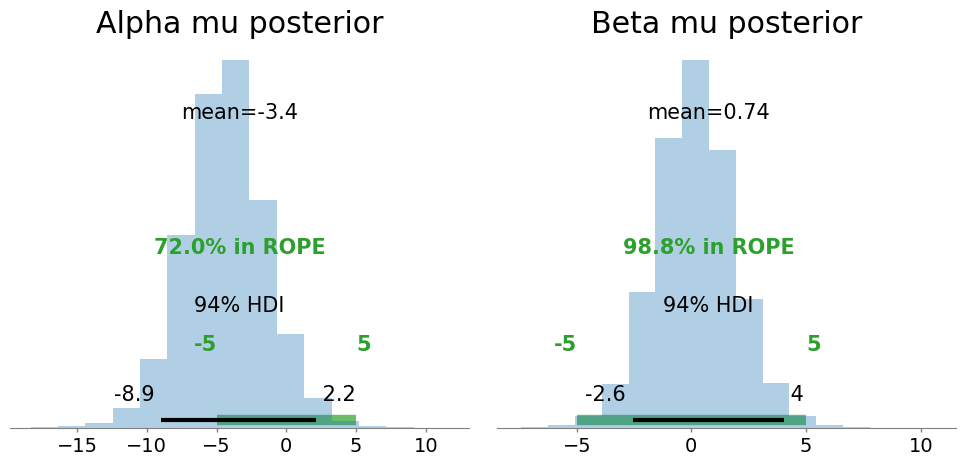

In [267]:
#Plot
abias_posterior_stack = az.extract(trace_alpha_bias.posterior)
bbias_posterior_stack = az.extract(trace_beta_bias.posterior)

fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
az.plot_posterior(abias_posterior_stack.mu.values,kind='hist', rope=(-rope_mu_diff,rope_mu_diff), ax=ax[0])
ax[0].set(title='Alpha mu posterior')
az.plot_posterior(bbias_posterior_stack.mu.values,kind='hist', rope=(-rope_mu_diff,rope_mu_diff), ax=ax[1])
ax[1].set(title='Beta mu posterior')
plt.show()

In [271]:
# Bayes factor
#first calculate the percent of posterior probability within the rope
prior_in_rope = (np.sum((abias_prior_stack.mu.values>-ROPE) & (abias_prior_stack.mu.values<ROPE)) / len(abias_prior_stack.mu.values))*100
post_in_rope = (np.sum((abias_posterior_stack.mu.values>-ROPE) & (abias_posterior_stack.mu.values<ROPE)) / len(abias_posterior_stack.mu.values))*100

#Calcualte bayes factor
BF_mu_diff = post_in_rope/prior_in_rope
BF_mu_diff

2.9875

## 2. Bias across 'true' scores

### Define the model

Here we regress true scores against the difference in scores. The proxy for true score is the mean of individual scores at Test 1 and Test 2 (the x axis on the Bland-Altman plot). 

$$ TestDifference \sim Normal(\mu, \sigma) $$
$$ \mu = \alpha + \beta*TestMean $$
$$ \alpha \sim Normal(0, 20) $$ 
$$ \beta \sim Normal(0,10) $$
$$ \sigma \sim Exp(20) $$

### Define the priors 

Given the rage of the data, we make an initial guess that the slope of this relationship is centered on 0 with a good amount of uncertainty to not overwhelm the likelihood: N(0,10). For the incercept, we assume that when the mean of the scores is 0, we make a guess that the difference in scores is centered on 0 with a wide SD: N(0,20. The sigma of the distibution of differences has an expected value of 20. 

### Organize the variables

In [99]:
#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]
#Means
alpha_mean = np.mean(alphas,axis=1)
beta_mean = np.mean(betas,axis=1)

### Calculcate the posteriors

In [138]:
#Alpha
trace_alpha_diff_regress, prior_samples_adiff_regress = bayes_simple_regression(alpha_diff, alpha_mean, intercept_prior=[0,5], slope_prior=[0,1])
#Beta
trace_beta_diff_regress, prior_samples_bdiff_regress = bayes_simple_regression(beta_diff, beta_mean, intercept_prior=[0,5], slope_prior=[0,1])

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 30 seconds.


### Model checks

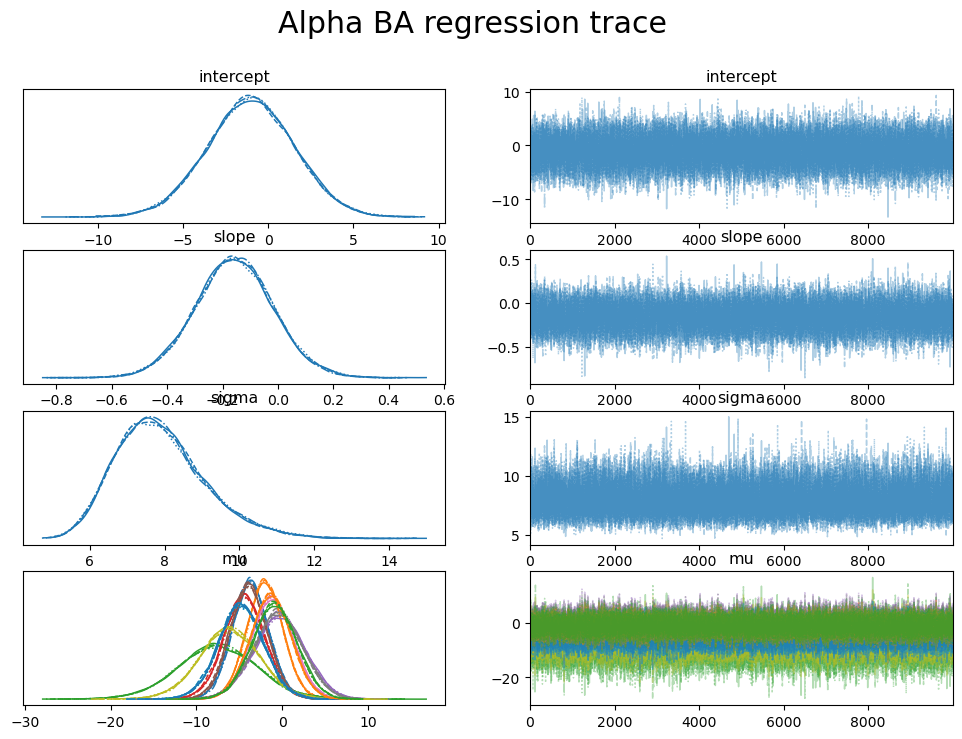

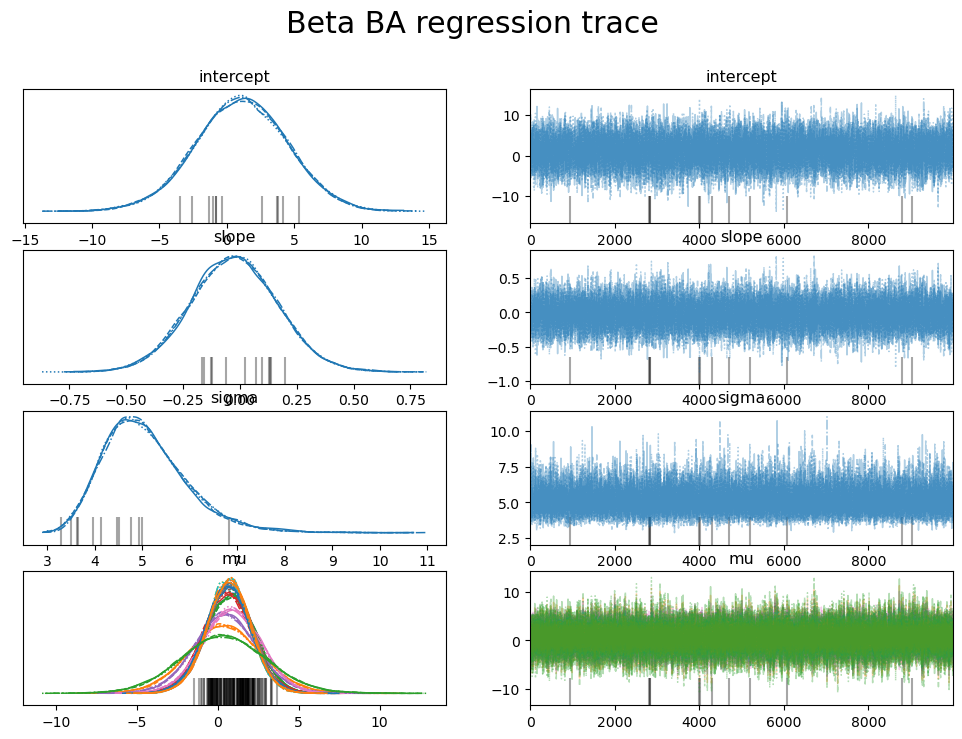

In [140]:
#Traces
#Alpha
az.plot_trace(trace_alpha_diff_regress)
plt.suptitle('Alpha BA regression trace')
plt.show()
#Beta
az.plot_trace(trace_beta_diff_regress)
plt.suptitle('Beta BA regression trace')
plt.show()

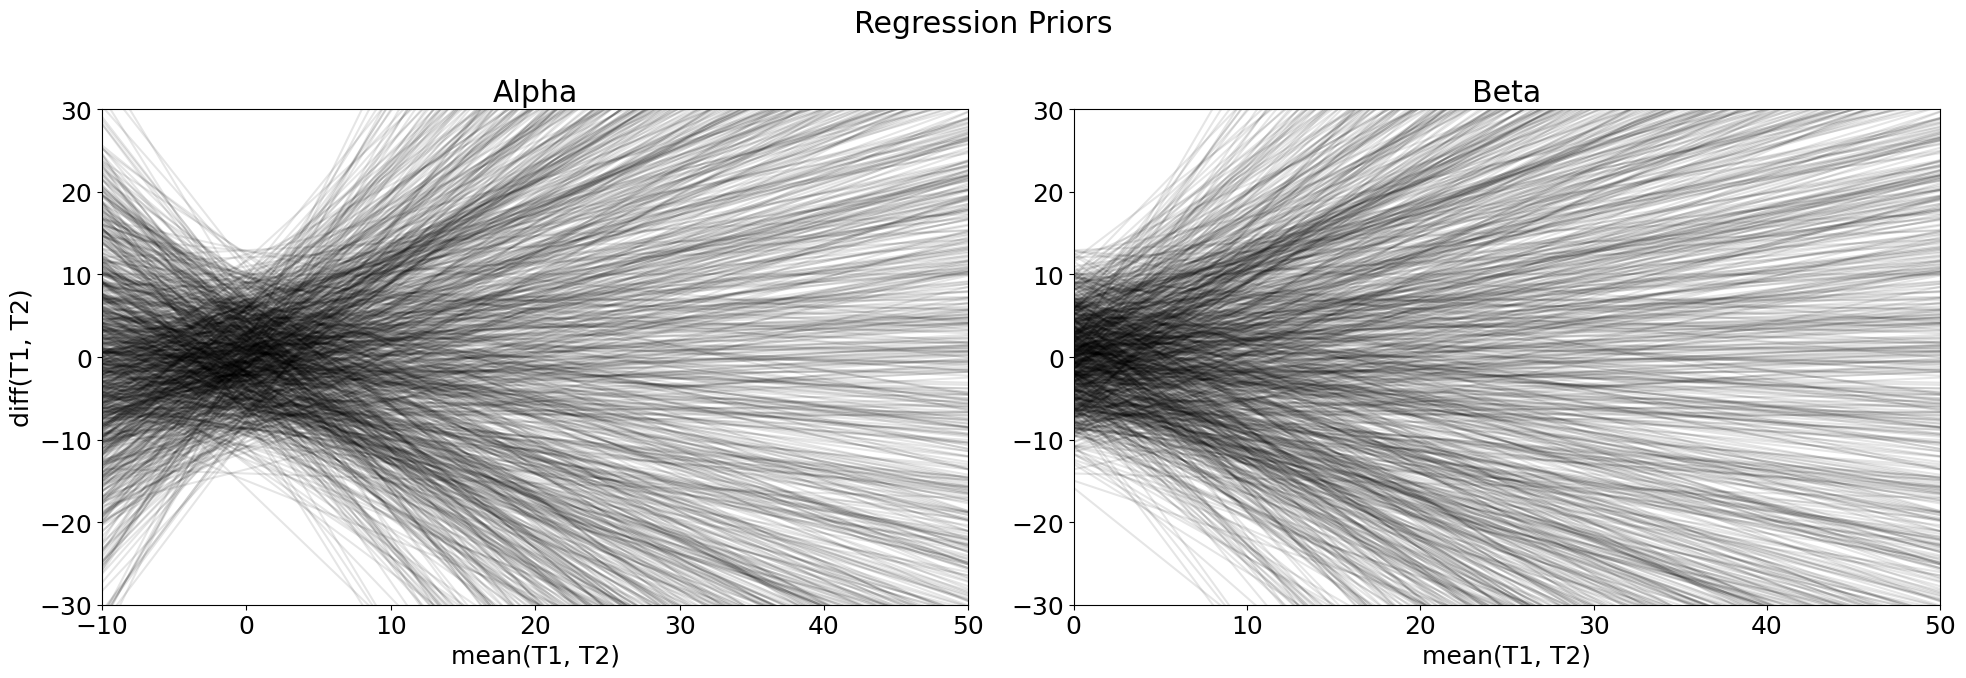

In [141]:
#Priors
abias_regress_prior_stack = az.extract(prior_samples_adiff_regress.prior, num_samples=num_samples, rng=RANDOM_SEED)
bbias_regress_prior_stack = az.extract(prior_samples_bdiff_regress.prior, num_samples=num_samples, rng=RANDOM_SEED)

#Priors
# Make sure the priors are reasonable 
fig, ax = plt.subplots(1,2, figsize=(20,7),tight_layout=True)

x_alpha = np.linspace(-10, 51, 100)
for a, b in zip(abias_regress_prior_stack.intercept.values, abias_regress_prior_stack.slope.values):
    y_alpha = a + b * x_alpha
    ax[0].plot(x_alpha, y_alpha, c="black", alpha=0.1)

x_beta = np.linspace(0, 51, 100)
for a, b in zip(bbias_regress_prior_stack.intercept.values, bbias_regress_prior_stack.slope.values):
    y_beta = a + b * x_beta
    ax[1].plot(x_beta, y_beta, c="black", alpha=0.1)
    
# ax.plot(np.arange(-10,51),np.zeros(61),'k--')
ax[0].set(xlabel='mean(T1, T2)', ylabel='diff(T1, T2)', xlim=(-10, 50), ylim=(-30,30), title='Alpha')
ax[1].set(xlabel='mean(T1, T2)', xlim=(0, 50), ylim=(-30,30), title='Beta')
plt.suptitle('Regression Priors')
plt.show()

**Prior justification:**

For these priors, first I manipulated the prior for the intercept. It is set at mu=0, sigma=5. First I increased the sigma to 20. First of all, this really increases the uncertainty. The prior predictive checks are now all over the place. This widens the posterior distributions, mostly for the intercepts. If I also widen the prior for the slope from mu=0, sigma=1 to sigma=5. This really does not change much.

Now Ill try narrowing. First I tied the intercept down with a sigma from 5 to 1. As expected this really narrows the posterior for intercept. Oddly, there are no more divergrences in the trace. Similarily, when I narrow down the prior for slope from 1 to 0.1, this narrows the posterior by a lot. I dont think it is good to narrow the posterior by this much. 

Lastly, I changed the priors for sigma. The one I am using are 0.05, and EV of 20. I also looked at an EV of 1 and 100. Neither changed the posterior a great deal. 

**ROPE justification:**

Here I define ropes for the intercept and slope. Lets start with the intercept. Here, the intercept is defined as the difference between the estimates on Test 1 and 2, when the mean of the estimates on Test 1 and 2 equals 0. In other words, when the true score is 0, what is the difference between the scores. We can use similar logic as above, where for practical purposes, a difference outside of 10mm on either side can be considered large.

Now for the slope. First we have to consider what the slope means in this context. Here the slope is a rate of change of estimate differences based on the true score. Thus, a slope of 0.1 means that if the true score changes 10mm, there is a 1mm change in score difference. If the test is perfectly unbiased, there should be a slope of 0. So what is the largest slope that is practically 0 for our purposes? If we dont think the true score is impacting the difference in scores, large changes in true score should not impact the difference in scores. 

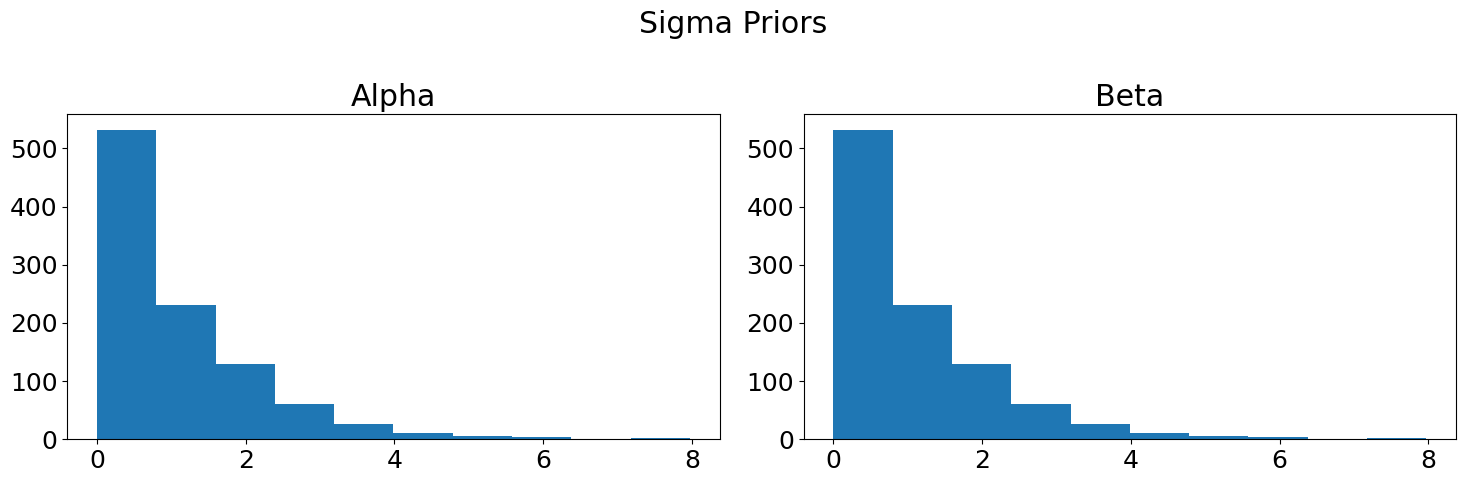

In [142]:
#Prior for sigma
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
ax[0].hist(abias_regress_prior_stack.sigma.values)
ax[0].set(title='Alpha')
ax[1].hist(bbias_regress_prior_stack.sigma.values)
ax[1].set(title='Beta')
plt.suptitle('Sigma Priors')
plt.show()

### Analyze posterior

In [104]:
alpha_regress_summary = az.summary(trace_alpha_diff_regress, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
print('Alpha posterior:')
display(alpha_regress_summary)
beta_regress_summary = az.summary(trace_beta_diff_regress, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
print('Beta posterior:')
display(beta_regress_summary)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.872  3.121    -7.031      5.266      0.022    0.016   20693.0   
slope      -0.161  0.185    -0.536      0.196      0.001    0.001   19977.0   
sigma      10.546  2.418     6.534     15.335      0.016    0.011   23597.0   

           ess_tail  r_hat  
intercept   23419.0    1.0  
slope       22242.0    1.0  
sigma       22697.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.906  3.775    -6.567      8.185      0.033    0.024   12979.0   
slope     -0.016  0.215    -0.440      0.404      0.002    0.001   12923.0   
sigma      6.213  1.461     3.796      9.152      0.012    0.008   15484.0   

           ess_tail  r_hat  
intercept   16410.0    1.0  
slope       15918.0    1.0  
sigma       13835.0    1.0

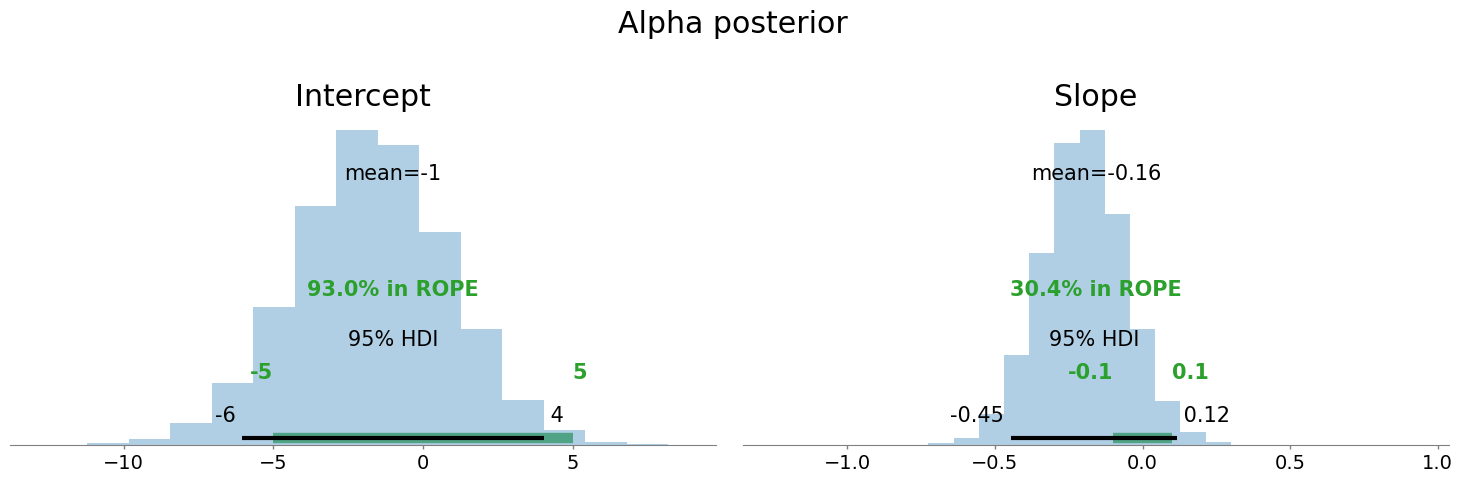

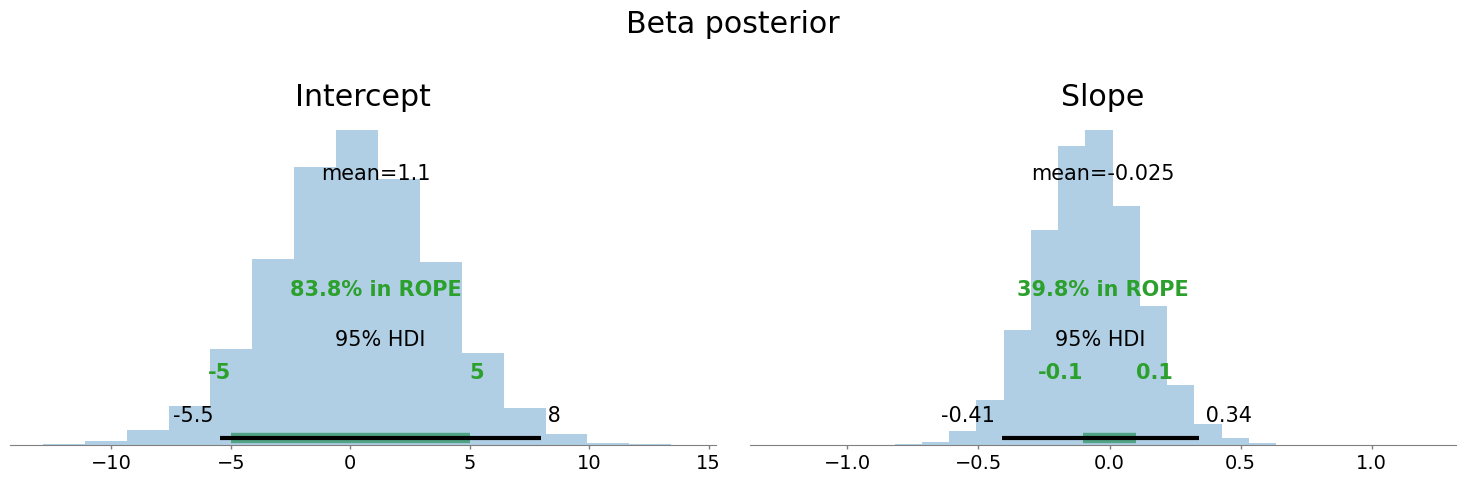

In [288]:
#Plot
abias_regress_posterior_stack = az.extract(trace_alpha_diff_regress.posterior)
bbias_regress_posterior_stack = az.extract(trace_beta_diff_regress.posterior)

fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
az.plot_posterior(abias_regress_posterior_stack.intercept.values,kind='hist', rope=(-5, 5), hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Intercept')
az.plot_posterior(abias_regress_posterior_stack.slope.values,kind='hist',  rope=(-0.1, 0.1), hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Slope')
plt.suptitle('Alpha posterior')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
az.plot_posterior(bbias_regress_posterior_stack.intercept.values,kind='hist', rope=(-5, 5), hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Intercept')
az.plot_posterior(bbias_regress_posterior_stack.slope.values,kind='hist',  rope=(-0.1, 0.1), hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Slope')
plt.suptitle('Beta posterior')
plt.show()

## 3. Limits of agreement (emperical)

In [106]:
#Limits of agreement
uplimit_alpha = np.mean(alpha_diff) + 1.96*np.std(alpha_diff, ddof=1)
lolimit_alpha = np.mean(alpha_diff) - 1.96*np.std(alpha_diff, ddof=1)

uplimit_beta = np.mean(beta_diff) + 1.96*np.std(beta_diff, ddof=1)
lolimit_beta = np.mean(beta_diff) - 1.96*np.std(beta_diff, ddof=1)

print('Alpha limits of agreement: ' + str(round(lolimit_alpha,1)) + ' to ' + str(round(uplimit_alpha,1)))
print('Beta limits of agreement: ' + str(round(lolimit_beta,1)) + ' to ' + str(round(uplimit_beta,1)))

Alpha limits of agreement: -22.3 to 15.5
Beta limits of agreement: -10.1 to 11.6


# Regression 

## Define the model

Scores on Test 2 are normally distributed with a mean depenednet on a regression model with an intercept and a slope with the predictor variable being the scores on Test 1:

$$ Test2 \sim Normal(\mu, \sigma) $$
$$ \mu = \alpha + \beta*Test1 $$
$$ \alpha \sim Normal(0, 20) $$ 
$$ \beta \sim Normal(0,1) $$
$$ \sigma \sim Exp(20) $$

## Define the priprs 

I made the prior for slope cenetered on 1 with a SD of 1. The prior for the sigma parameter is 0.05. This is the same as an expected value of 20 becauase the parameterization for the Exponential function is: mean = 1/lambda. Where the lambda is the parameter.

## Orgainze the variables 

In [145]:
t1_a = alphas[:,0] 
t2_a = alphas[:,1]

t1_b = betas[:,0] 
t2_b = betas[:,1]

## Calculcate the posteriors

In [202]:
#Alpha
trace_alpha_regress, prior_samples_aregress = bayes_simple_regression(t2_a, t1_a, intercept_prior=[0,20], slope_prior=[0,0.5])
#Beta
trace_beta_regress, prior_samples_bregress = bayes_simple_regression(t2_b, t1_b, intercept_prior=[0,20], slope_prior=[0,0.5])

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 33 seconds.


## Model checks

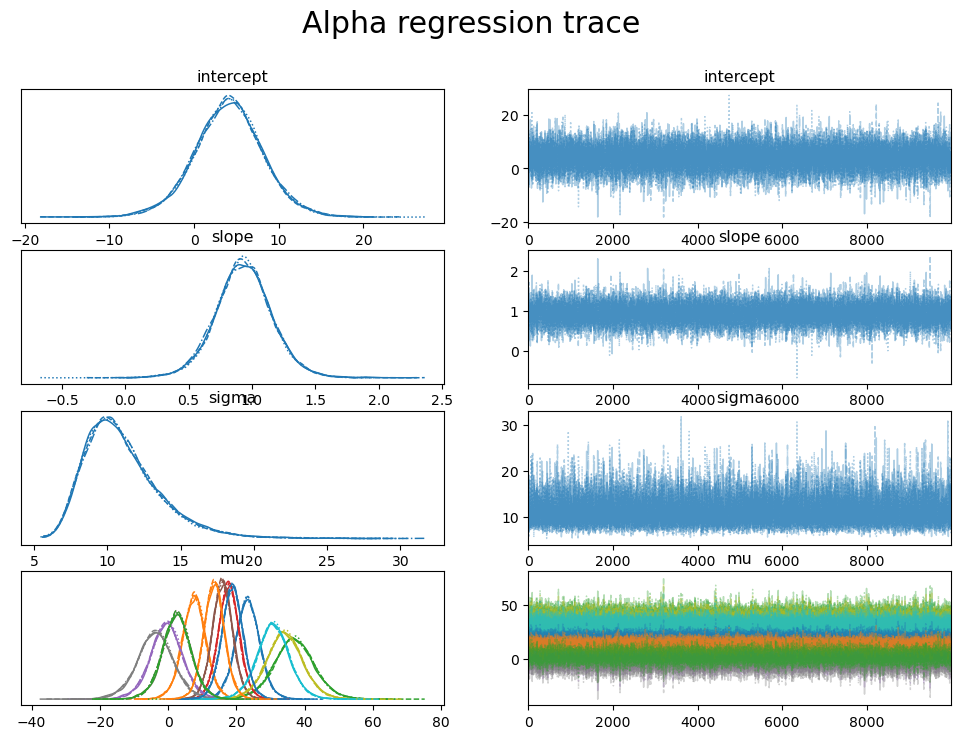

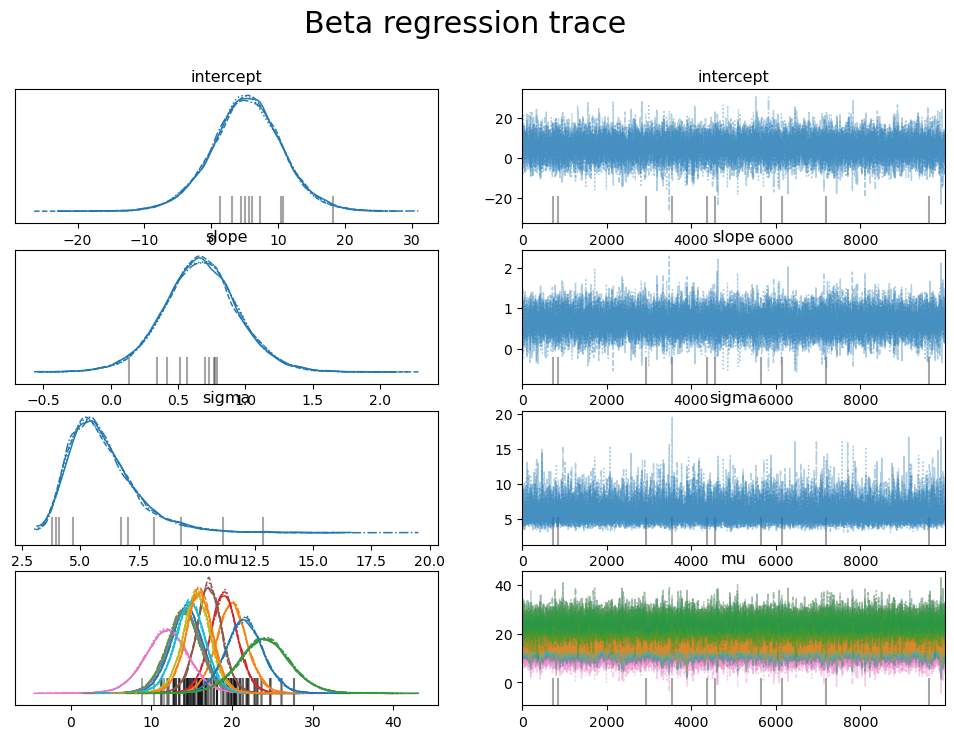

In [200]:
#Traces
#Alpha
az.plot_trace(trace_alpha_regress)
plt.suptitle('Alpha regression trace')
plt.show()
#Beta
az.plot_trace(trace_beta_regress)
plt.suptitle('Beta regression trace')
plt.show()

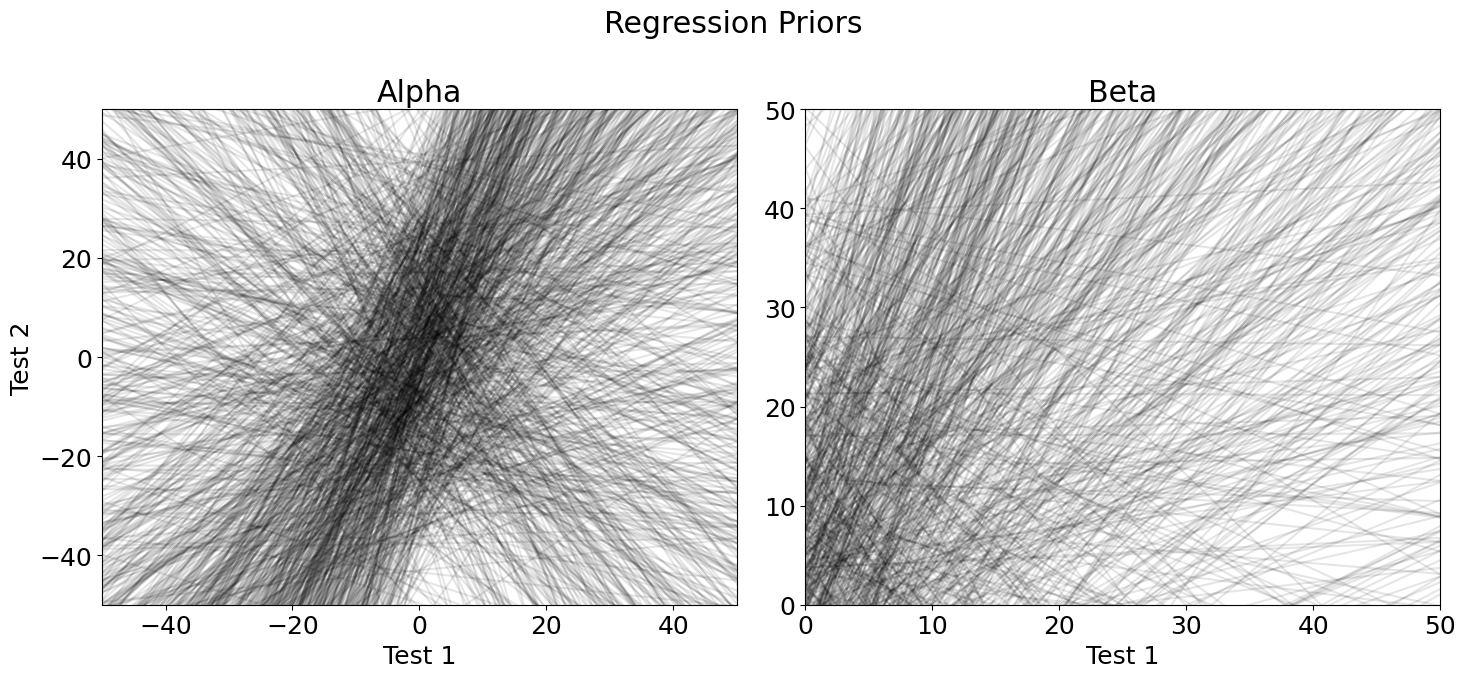

In [201]:
#Make sure the priors are reasonable 
aregress_prior_stack = az.extract(prior_samples_aregress.prior, num_samples=num_samples, rng=RANDOM_SEED)
bregress_prior_stack = az.extract(prior_samples_bregress.prior, num_samples=num_samples, rng=RANDOM_SEED)

fig, ax = plt.subplots(1,2, figsize=(15,7),tight_layout=True)

x_alpha = np.linspace(-50, 51, 100)
for a, b in zip(aregress_prior_stack.intercept.values, aregress_prior_stack.slope.values):
    y_alpha = a + b * x_alpha
    ax[0].plot(x_alpha, y_alpha, c="black", alpha=0.1)

x_beta = np.linspace(0, 51, 100)
for a, b in zip(bregress_prior_stack.intercept.values, bregress_prior_stack.slope.values):
    y_beta = a + b * x_beta
    ax[1].plot(x_beta, y_beta, c="black", alpha=0.1)
    
# ax.plot(np.arange(-10,51),np.zeros(61),'k--')
ax[0].set(xlabel='Test 1', ylabel='Test 2', xlim=(-50, 50), ylim=(-50,50), title='Alpha')
ax[1].set(xlabel='Test 1', xlim=(0, 50), ylim=(0,50), title='Beta')
plt.suptitle('Regression Priors')
plt.show()

Moving onto the regression analysis. I started with priors for the intercept of mu=0, sigma=20 and the slope of mu=1, sigma=2. 

This posterior is robust to pretty much all changes I made. Sometimes the 95% HDIs are narrower or wider for the slopes and intercepts 
If I widen the intercept priors from 20 to 50, this really doesnt change the posterior at all. If I narrow the intercept to around 5, this narrows the beta estimates for intercept and slope but does not change the threshold estimates very much.
For the slope priors, I have them centered on 1 with a sigma of 2. I tried narrowing the slope down to 1 but this didnt change the estimates for slope very much. 




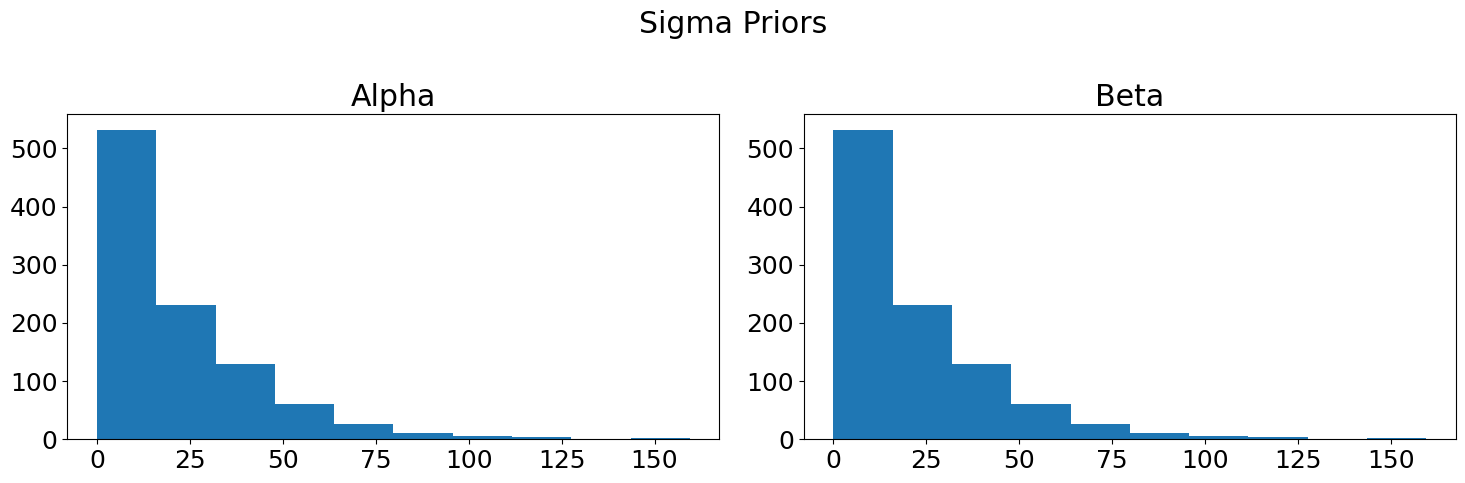

In [193]:
#Prior for sigma
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
ax[0].hist(aregress_prior_stack.sigma)
ax[0].set(title='Alpha')
ax[1].hist(bregress_prior_stack.sigma)
ax[1].set(title='Beta')
plt.suptitle('Sigma Priors')
plt.show()

## Analyze the posterior

In [198]:
regress_summary_alpha = az.summary(trace_alpha_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
regress_summary_beta = az.summary(trace_beta_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
print('Alpha posterior:')
display(regress_summary_alpha)
print('Beta posterior:')
display(regress_summary_beta)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   4.090  3.960    -3.516     12.276      0.028    0.021   20646.0   
slope       0.934  0.216     0.518      1.373      0.002    0.001   20849.0   
sigma      10.933  2.592     6.773     16.255      0.019    0.014   20423.0   

           ess_tail  r_hat  
intercept   22641.0    1.0  
slope       22180.0    1.0  
sigma       21807.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  4.897  5.156    -5.248     15.265      0.048    0.034   11796.0   
slope      0.689  0.270     0.150      1.221      0.002    0.002   11908.0   
sigma      5.908  1.419     3.464      8.638      0.013    0.009    9672.0   

           ess_tail  r_hat  
intercept   13476.0    1.0  
slope       13826.0    1.0  
sigma        5784.0    1.0

In [154]:
regress_summary_alpha = az.summary(trace_alpha_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
regress_summary_beta = az.summary(trace_beta_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
print('Alpha posterior:')
display(regress_summary_alpha)
print('Beta posterior:')
display(regress_summary_beta)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   4.292  4.143    -4.243     12.329      0.030    0.022   19249.0   
slope       0.925  0.225     0.475      1.372      0.002    0.001   19424.0   
sigma      11.000  2.637     6.725     16.313      0.020    0.014   18850.0   

           ess_tail  r_hat  
intercept   20929.0    1.0  
slope       20788.0    1.0  
sigma       20100.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.562  5.511    -5.415     16.482      0.052    0.037   11455.0   
slope      0.653  0.289     0.075      1.228      0.003    0.002   11540.0   
sigma      5.940  1.446     3.588      8.815      0.013    0.009   11799.0   

           ess_tail  r_hat  
intercept   13389.0    1.0  
slope       13144.0    1.0  
sigma       10983.0    1.0

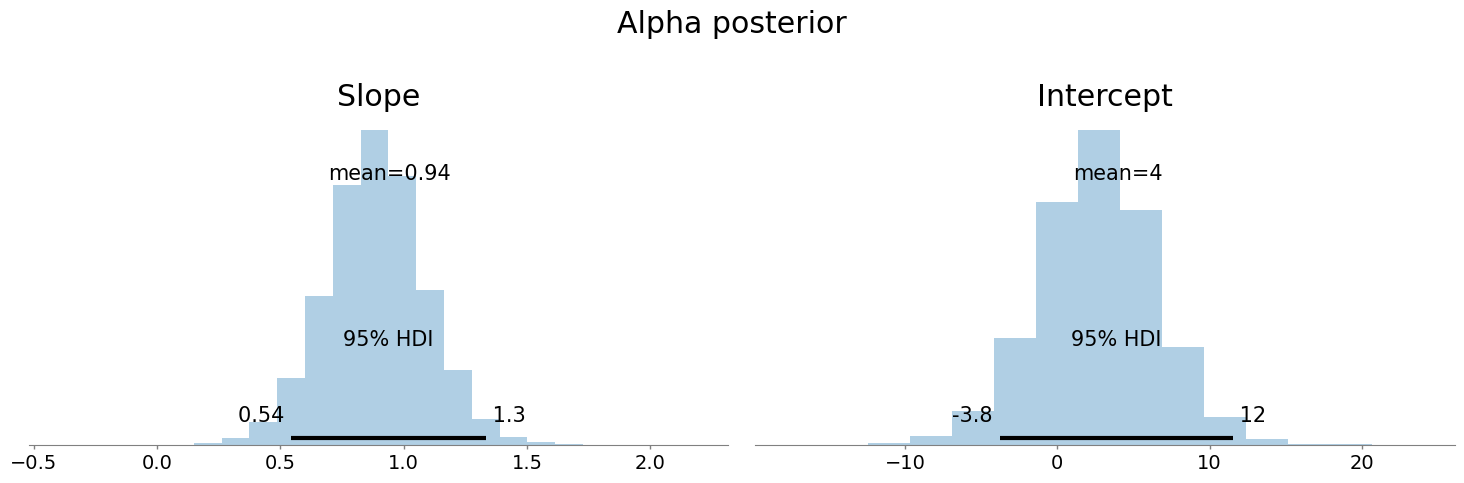

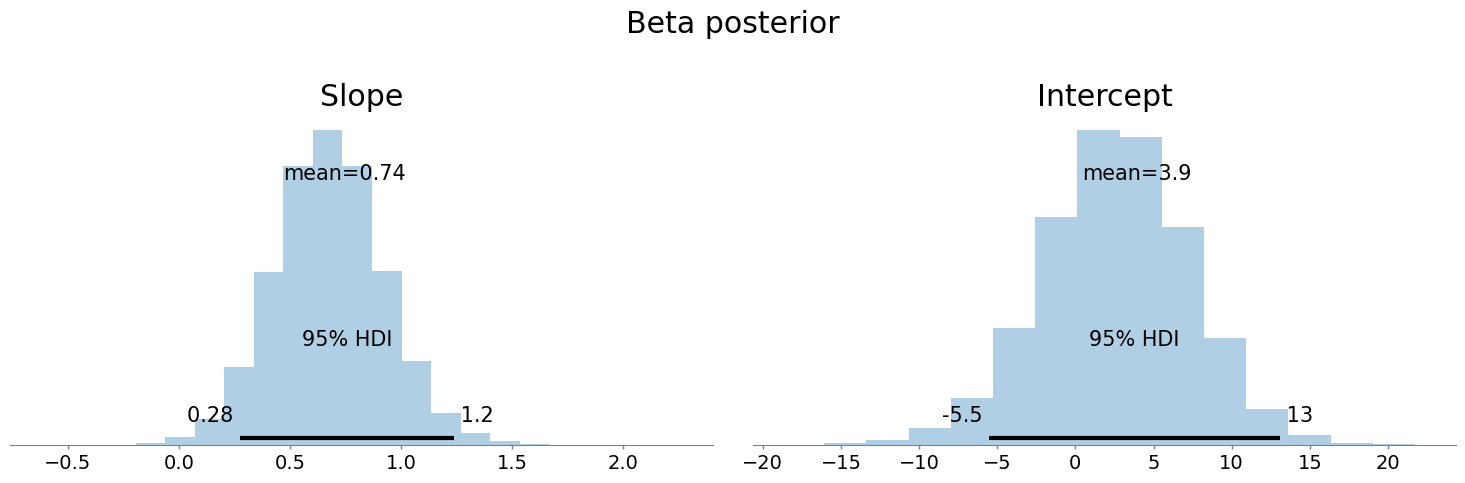

In [205]:
#Plot
aregress_posterior_stack = az.extract(trace_alpha_regress.posterior)
bregress_posterior_stack = az.extract(trace_beta_regress.posterior)

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(aregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(aregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Alpha posterior')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(bregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(bregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Beta posterior')
plt.show()

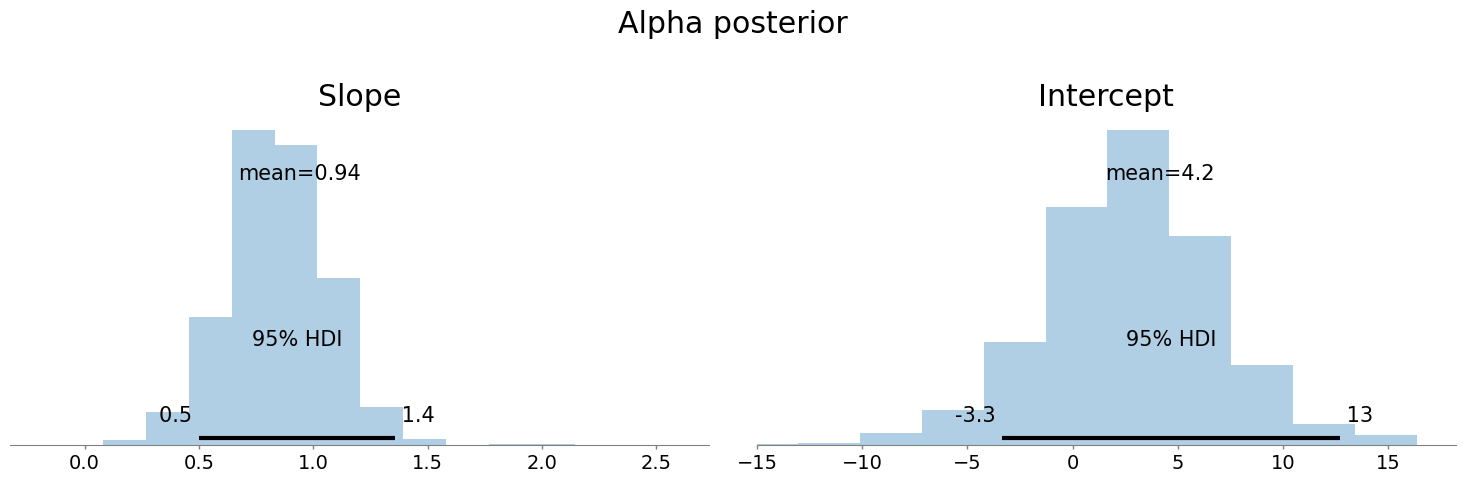

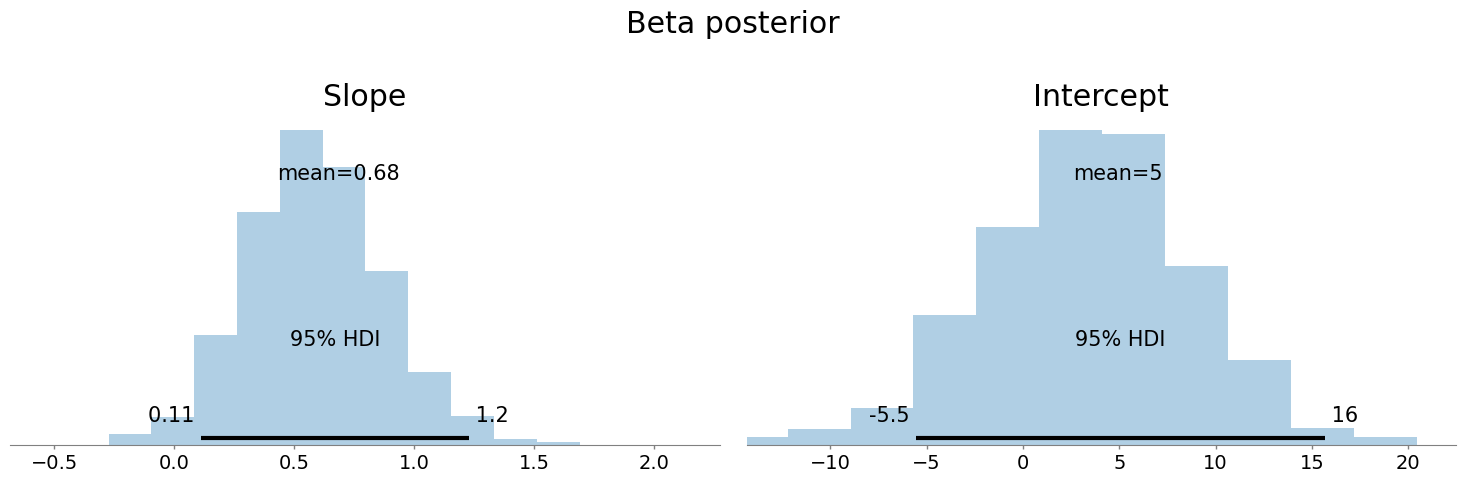

In [159]:
#Plot
aregress_posterior_stack = az.extract(trace_alpha_regress.posterior, num_samples=num_samples, rng=RANDOM_SEED)
bregress_posterior_stack = az.extract(trace_beta_regress.posterior, num_samples=num_samples, rng=RANDOM_SEED)

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(aregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(aregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Alpha posterior')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(bregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(bregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Beta posterior')
plt.show()

# Combined Figure

## Prep

In [246]:
#Prep plot for alpha BA regression
x_adiff_regress = np.arange(-5, 45)
mu_hat_adiff_regress = np.zeros((len(x_adiff_regress), len(abias_regress_posterior_stack.intercept.values)))
for i, x in enumerate(x_adiff_regress):
    mu_hat_adiff_regress[i] = abias_regress_posterior_stack.intercept.values + abias_regress_posterior_stack.slope.values*x
    
#Prep plot for beta BA regression
x_bdiff_regress = np.arange(5, 35)
mu_hat_bdiff_regress = np.zeros((len(x_bdiff_regress), len(bbias_regress_posterior_stack.intercept.values)))
for i, x in enumerate(x_bdiff_regress):
    mu_hat_bdiff_regress[i] = bbias_regress_posterior_stack.intercept.values + bbias_regress_posterior_stack.slope.values*x

#Prep plot for alpha regression
x_aregress = np.arange(-10, 41)
mu_hat_alpha_regress = np.zeros((len(x_aregress), len(aregress_posterior_stack.intercept.values)))
for i, x in enumerate(x_aregress):
    mu_hat_alpha_regress[i] = aregress_posterior_stack.intercept.values + aregress_posterior_stack.slope.values*x

#Prep plot for beta regression
x_bregress = np.arange(5, 35)
mu_hat_beta_regress = np.zeros((len(x_bregress), len(bregress_posterior_stack.intercept.values)))
for i, x in enumerate(x_bregress):
    mu_hat_beta_regress[i] = bregress_posterior_stack.intercept.values + bregress_posterior_stack.slope.values*x

## Plot

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


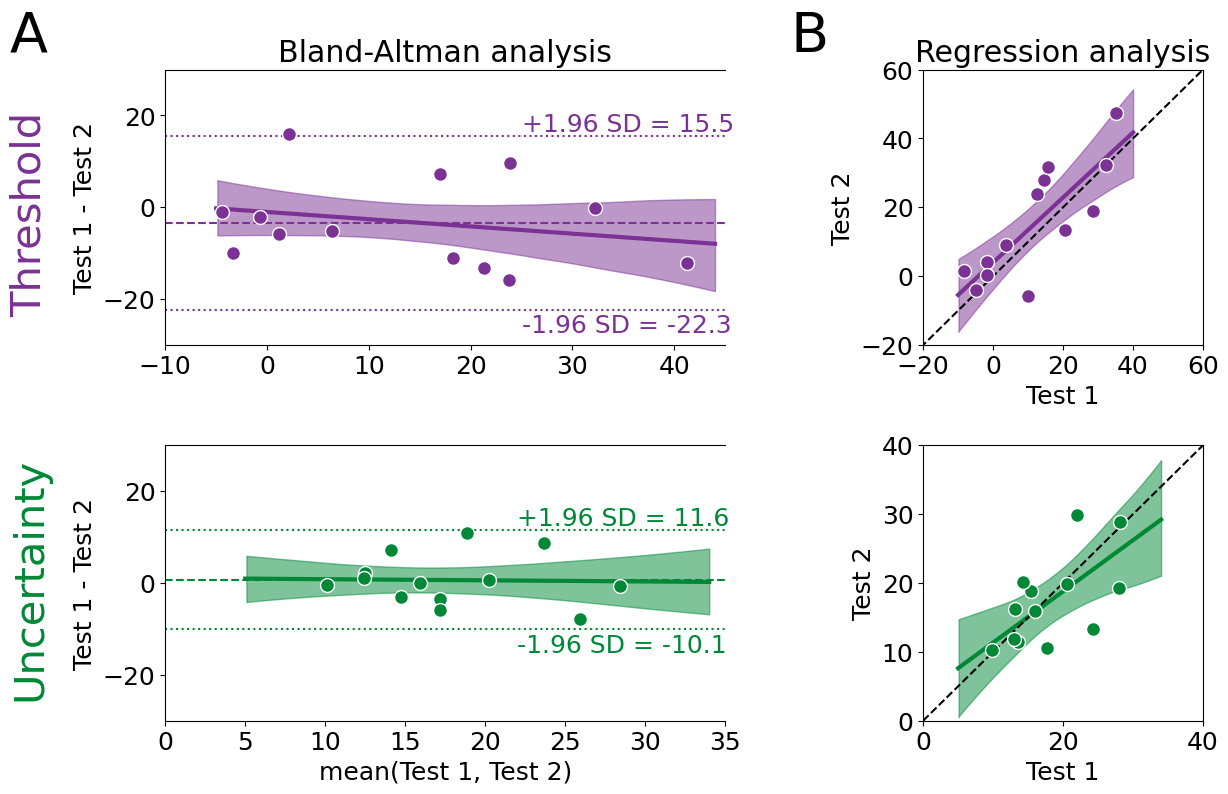

In [247]:
fig, ax = plt.subplots(2,2, figsize=(12,8), gridspec_kw={'width_ratios': [2, 1]},tight_layout=True)
x_a = np.arange(-10,71)
x_b = np.arange(0,51)

#Alpha bland-altman
az.plot_hdi(x_adiff_regress, mu_hat_adiff_regress.T, color=color_a, ax=ax[0,0], hdi_prob=0.95)
ax[0,0].plot(x_adiff_regress, np.mean(mu_hat_adiff_regress, axis=1), c=color_a, lw=3)
ax[0,0].plot(x_a,np.ones(81)*a_bias_summary["mean"][0],'--', color=color_a)
# ax[0,0].text(45, a_bias_summary["mean"][0]+1, 'Mean [95% HDI]', color=color_a)
# ax[0,0].text(45, a_bias_summary["mean"][0]-5, ' = ' + str(round(a_bias_summary["mean"][0])) + ' [' +
#              str(round(a_bias_summary["hdi_2.5%"][0])) + ' ' + str(round(a_bias_summary["hdi_97.5%"][0])) + ']',
#             color=color_a)
ax[0,0].plot(x_a, np.ones(81)*uplimit_alpha,color=color_a, ls=':')
ax[0,0].text(25, uplimit_alpha+1, '+1.96 SD = ' +str(round(uplimit_alpha,1)) + '         ', color=color_a)
ax[0,0].plot(x_a, np.ones(81)*lolimit_alpha,color=color_a, ls=':')
ax[0,0].text(25, lolimit_alpha-5, '-1.96 SD = ' +str(round(lolimit_alpha,1)), color=color_a)
ax[0,0].plot(alpha_mean,alpha_diff, 'o', c=color_a, ms=10, mec='w')
ax[0,0].set(ylabel='Test 1 - Test 2', xlim=(-10, 45), ylim=(-30,30), title='Bland-Altman analysis')
right_side = ax[0,0].spines["right"]
right_side.set_visible(False)
ax[0,0].patch.set_alpha(0)

#Beta Bland-altman
az.plot_hdi(x_bdiff_regress, mu_hat_bdiff_regress.T, color=color_b, ax=ax[1,0], hdi_prob=0.95)
ax[1,0].plot(x_bdiff_regress, np.mean(mu_hat_bdiff_regress, axis=1), c=color_b, lw=3)
ax[1,0].plot(x_b, np.ones(51)*uplimit_beta,color=color_b, ls=':')
ax[1,0].text(22, uplimit_beta+1, '+1.96 SD = ' +str(round(uplimit_beta,1)), color=color_b)
ax[1,0].plot(x_b, np.ones(51)*lolimit_beta,color=color_b, ls=':')
ax[1,0].text(22, lolimit_beta-5, '-1.96 SD = ' +str(round(lolimit_beta,1)), color=color_b)
ax[1,0].plot(x_b,np.ones(51)*b_bias_summary["mean"][0],'--', color=color_b)
ax[1,0].plot(beta_mean,beta_diff, 'o', c=color_b, ms=10, mec='w')
# ax[1,0].text(35, b_bias_summary["mean"][0]+1, 'Mean [95% HDI]', color=color_b)
# ax[1,0].text(35, b_bias_summary["mean"][0]-5, ' = ' + str(round(b_bias_summary["mean"][0])) + ' [' +
#              str(round(b_bias_summary["hdi_2.5%"][0])) + ' ' + str(round(b_bias_summary["hdi_97.5%"][0])) + ']',
#             color=color_b)
ax[1,0].set(xlabel='mean(Test 1, Test 2)', ylabel='Test 1 - Test 2', xlim=(0, 35), ylim=(-30,30))
right_side = ax[1,0].spines["right"]
right_side.set_visible(False)
ax[1,0].patch.set_alpha(0)

#Alpha regression
az.plot_hdi(x_aregress, mu_hat_alpha_regress.T, color=color_a, ax=ax[0,1], hdi_prob=0.95)
ax[0,1].plot(x_aregress, np.mean(mu_hat_alpha_regress, axis=1), c=color_a, lw=3)
ax[0,1].plot(np.arange(-50,61),np.arange(-50,61),'k--')
ax[0,1].plot(t1_a,t2_a, 'o', c=color_a, ms=10, mec='w')
ax[0,1].set(xlabel='Test 1', ylabel='Test 2', xlim=(-20,50), ylim=(-20,50), xticks=np.arange(-20,80,20), yticks=np.arange(-20,80,20), title='Regression analysis')
ax[0,1].patch.set_alpha(0)

#Beta regression
az.plot_hdi(x_bregress, mu_hat_beta_regress.T, color=color_b, ax=ax[1,1], hdi_prob=0.95)
ax[1,1].plot(x_bregress, np.mean(mu_hat_beta_regress, axis=1), c=color_b, lw=3)
ax[1,1].plot(np.arange(0,41),np.arange(0,41),'k--')
ax[1,1].plot(t1_b,t2_b, 'o', c=color_b, ms=10, mec='w')
ax[1,1].set(xlabel='Test 1', ylabel='Test 2', xlim=(0, 40), ylim=(0,40))
ax[1,1].patch.set_alpha(0)

#text
fig.text(-0.03, 0.63, 'Threshold', rotation='vertical', fontsize=30, c=color_a)
fig.text(-0.03, 0.15, 'Uncertainty', rotation='vertical', fontsize=30, c=color_b)

fig.text(-0.03, 0.95, 'A', fontsize=40, c='k')
fig.text(0.62, 0.95, 'B', fontsize=40, c='k')
fig.patch.set_alpha(0)

#Save
plt.savefig(fig_path + '/Results_Fig' + extension, transparent=True, bbox_inches='tight', pad_inches=1, edgecolor='w', dpi=1500)

# ICC (frequentist)

## Alpha

In [276]:
# Alpha
icc_a_df = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(alphas,len(alphas)*2)})
icc_alpha = pg.intraclass_corr(data=icc_a_df, targets='subj', raters='test', ratings='data')
icc_alpha.set_index('Type')
icc_alpha.loc[1]

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

Type                           ICC2
Description    Single random raters
ICC                        0.796358
F                          9.180985
df1                              12
df2                              12
pval                       0.000268
CI95%                  [0.48, 0.93]
Name: 1, dtype: object

## Beta

In [277]:
# Beta
icc_b_df = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(betas,len(betas)*2)})
icc_beta = pg.intraclass_corr(data=icc_b_df, targets='subj', raters='test', ratings='data')
icc_beta.set_index('Type')
icc_beta.loc[1]

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

Type                           ICC2
Description    Single random raters
ICC                        0.612006
F                          3.965313
df1                              12
df2                              12
pval                       0.012066
CI95%                  [0.11, 0.86]
Name: 1, dtype: object

# Agreement on 50 trials

## Load the data

In [278]:
unique_tests = ['a','b']
alphas_50, betas_50 = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(test[test.Test==test_id].loc[49])
        # # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas_50[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[49]+BslDiff
        betas_50[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[49]
        
alpha_diff_50 = alphas_50[:,0] - alphas_50[:,1]
beta_diff_50 = betas_50[:,0] - betas_50[:,1]

alpha_mean_50 = np.mean(alphas_50,axis=1)
beta_mean_50 = np.mean(betas_50,axis=1)

#Calculcate Limits of agreement
uplimit_alpha_50 = np.mean(alpha_diff_50) + 1.96*np.std(alpha_diff_50, ddof=1)
lolimit_alpha_50 = np.mean(alpha_diff_50) - 1.96*np.std(alpha_diff_50, ddof=1)

uplimit_beta_50 = np.mean(beta_diff_50) + 1.96*np.std(beta_diff_50, ddof=1)
lolimit_beta_50 = np.mean(beta_diff_50) - 1.96*np.std(beta_diff_50, ddof=1)

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_20676/2094387711.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


## Bias 

In [279]:
#Alpha
_, trace_abias_50, = bayes_onesamp_ttest(alpha_diff_50, prior=[0,20])
#Beta
_, trace_bbias_50 = bayes_onesamp_ttest(beta_diff_50, prior=[0,20])

a_bias_summary_50 = az.summary(trace_abias_50, var_names=["mu", "sigma"], hdi_prob=0.95)
b_bias_summary_50 = az.summary(trace_bbias_50, var_names=["mu", "sigma"], hdi_prob=0.95)

Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 25 seconds.
Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 24 seconds.


## Bias across true scores 

In [280]:
#Alpha
trace_alpha_diff_regress_50, _ = bayes_simple_regression(alpha_diff_50, alpha_mean_50, intercept_prior=[0,5], slope_prior=[0,1])
#Beta
trace_beta_diff_regress_50, _ = bayes_simple_regression(beta_diff_50, beta_mean_50, intercept_prior=[0,5], slope_prior=[0,1])
alpha_regress_summary_50 = az.summary(trace_alpha_diff_regress_50, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
beta_regress_summary_50 = az.summary(trace_beta_diff_regress_50, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 27 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 31 seconds.


## Regression

In [281]:
#Alpha
trace_alpha_regress_50, _ = bayes_simple_regression(alphas_50[:,1], alphas_50[:,0], intercept_prior=[0,20], slope_prior=[1,2])
#Beta
trace_beta_regress_50, _ = bayes_simple_regression(betas_50[:,1], betas_50[:,0], intercept_prior=[0,20], slope_prior=[1,2])
regress_summary_alpha_50 = az.summary(trace_alpha_regress_50, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
regress_summary_beta_50 = az.summary(trace_beta_regress_50, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 34 seconds.


## ICC

In [282]:
# Alpha
icc_a_df_50 = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(alphas_50,len(alphas_50)*2)})
icc_alpha_50 = pg.intraclass_corr(data=icc_a_df_50, targets='subj', raters='test', ratings='data')
# Beta
icc_b_df_50 = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(betas_50,len(betas_50)*2)})
icc_beta_50 = pg.intraclass_corr(data=icc_b_df_50, targets='subj', raters='test', ratings='data')

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

## Summary table

In [300]:
# make a table
headers = ["Limits of agreement", "Bland-Altman mean bias", "Bland-Altman bias regression", "Test 1 vs Test 2 regression", "ICC [2,1]"]
headers
row1 = ["Threshold (alpha)", " ", " ", " ", " ", " "]
row2 = ["50 Trials", 
        str(round(lolimit_alpha_50,1)) + ' to ' + str(round(uplimit_alpha_50,1)), 
        str(round(a_bias_summary_50["mean"][0],1)) + ' [' + str(round(a_bias_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(a_bias_summary_50["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(alpha_regress_summary_50["mean"][1],2)) + ' [' + str(round(alpha_regress_summary_50["hdi_2.5%"][1],2)) + ' ' + str(round(alpha_regress_summary_50["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_alpha_50["mean"][1],2)) + ' [' + str(round(regress_summary_alpha_50["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_alpha_50["hdi_97.5%"][1],2)) + ']',
        str(round(icc_alpha_50.loc[1][2],2)) + ' ' + str(icc_alpha_50["CI95%"][1])]
row3 = [" ", " ", " ", 
        'Intercept = ' + str(round(alpha_regress_summary_50["mean"][0],1)) + ' [' + str(round(alpha_regress_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(alpha_regress_summary_50["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_alpha_50["mean"][0],1)) + ' [' + str(round(regress_summary_alpha_50["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_alpha_50["hdi_97.5%"][0],1)) + ']',]
row4 = ["75 Trials", 
        str(round(lolimit_alpha,1)) + ' to ' + str(round(uplimit_alpha,1)),
        str(round(a_bias_summary["mean"][0],1)) + ' [' + str(round(a_bias_summary["hdi_2.5%"][0],1)) + ' ' + str(round(a_bias_summary["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(alpha_regress_summary["mean"][1],2)) + ' [' + str(round(alpha_regress_summary["hdi_2.5%"][1],2)) + ' ' + str(round(alpha_regress_summary["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_alpha["mean"][1],2)) + ' [' + str(round(regress_summary_alpha["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_alpha["hdi_97.5%"][1],2)) + ']',
        str(round(icc_alpha.loc[1][2],2)) + ' ' + str(icc_alpha["CI95%"][1])]
row5 = [" ", " ", " ", 
        'Intercept = ' + str(round(alpha_regress_summary["mean"][0],1)) + ' [' + str(round(alpha_regress_summary["hdi_2.5%"][0],1)) + ' ' + str(round(alpha_regress_summary["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_alpha["mean"][0],1)) + ' [' + str(round(regress_summary_alpha["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_alpha["hdi_97.5%"][0],1)) + ']']
row6 = ["Uncertainty (beta)", " ", " ", " ", " ", " "]
row7 = ["50 Trials", 
        str(round(lolimit_beta_50,1)) + ' to ' + str(round(uplimit_beta_50,1)),
        str(round(b_bias_summary_50["mean"][0],1)) + ' [' + str(round(b_bias_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(b_bias_summary_50["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(beta_regress_summary_50["mean"][1],2)) + ' [' + str(round(beta_regress_summary_50["hdi_2.5%"][1],2)) + ' ' + str(round(beta_regress_summary_50["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_beta_50["mean"][1],2)) + ' [' + str(round(regress_summary_beta_50["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_beta_50["hdi_97.5%"][1],2)) + ']',
        str(round(icc_beta_50.loc[1][2],2)) + ' ' + str(icc_beta_50["CI95%"][1])]
row8 = [" ", " ", " "," "
        'Intercept = ' + str(round(beta_regress_summary_50["mean"][0],1)) + ' [' + str(round(beta_regress_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(beta_regress_summary_50["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_beta_50["mean"][0],1)) + ' [' + str(round(regress_summary_beta_50["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_beta_50["hdi_97.5%"][0],1)) + ']',]
row9 = ["75 Trials", 
        str(round(lolimit_beta,1)) + ' to ' + str(round(uplimit_beta,1)),
        str(round(b_bias_summary["mean"][0],1)) + ' [' + str(round(b_bias_summary["hdi_2.5%"][0],1)) + ' ' + str(round(b_bias_summary["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(beta_regress_summary["mean"][1],2)) + ' [' + str(round(beta_regress_summary["hdi_2.5%"][1],2)) + ' ' + str(round(beta_regress_summary["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_beta["mean"][1],2)) + ' [' + str(round(regress_summary_beta["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_beta["hdi_97.5%"][1],2)) + ']',
        str(round(icc_beta.loc[1][2],2)) + ' ' + str(icc_beta_50["CI95%"][1])]
row10 = [" ", " ", " ", 
        'Intercept = ' + str(round(beta_regress_summary["mean"][0],1)) + ' [' + str(round(beta_regress_summary["hdi_2.5%"][0],1)) + ' ' + str(round(beta_regress_summary["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_beta["mean"][0],1)) + ' [' + str(round(regress_summary_beta["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_beta["hdi_97.5%"][0],1)) + ']',]
table = [row1, row2, row3, row4, row5, row6, row7, row8, row9, row10]
print(tabulate(table, headers=headers))

                    Limits of agreement    Bland-Altman mean bias    Bland-Altman bias regression    Test 1 vs Test 2 regression    ICC [2,1]
------------------  ---------------------  ------------------------  ------------------------------  -----------------------------  ----------------
Threshold (alpha)
50 Trials           -22.3 to 15.7          -3.2 [-9.2 2.7]           Slope = -0.18 [-0.58 0.21]      Slope = 0.93 [0.45 1.39]       0.78 [0.43 0.92]
                                                                     Intercept = -0.8 [-6.8 5.5]     Intercept = 3.9 [-3.9 11.9]
75 Trials           -22.3 to 15.5          -3.4 [-9.1 2.5]           Slope = -0.16 [-0.54 0.2]       Slope = 0.93 [0.52 1.37]       0.8 [0.48 0.93]
                                                                     Intercept = -0.9 [-7.0 5.3]     Intercept = 4.1 [-3.5 12.3]
Uncertainty (beta)
50 Trials           -9.3 to 10.2           0.5 [-2.6 3.6]            Slope = 0.02 [-0.41 0.45]       Slope = 0.58 [0.

In [284]:
#Standard error of measurement = SD of scores * sqrt(1-reliability)
np.std(alphas[:,0],ddof=1) * np.sqrt(1-icc_alpha.loc[1][2])

6.467663099564264

In [285]:
np.std(betas[:,0],ddof=1) * np.sqrt(1-icc_beta.loc[1][2])

3.706633393875136

In [286]:
np.std(alphas_50[:,0],ddof=1) * np.sqrt(1-icc_alpha_50.loc[1][2])

6.409732556207735

In [287]:
np.std(betas_50[:,0],ddof=1) * np.sqrt(1-icc_beta_50.loc[1][2])

3.4856513530833944